# **임대주택 단지 내 적정 주차수요 예측 대회**

2021년 7월 13일, 다시 하나둘 제대로 데이터를 살펴보겠습니다. 추가변수도 필요해보입니다.

In [118]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [119]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [1083]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor, LassoLarsCV

In [121]:
from pycaret.regression import *

In [932]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [933]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [934]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [935]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [936]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [937]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [938]:
train.loc[(train['버스'].isnull()) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분    지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
2315  C1649   575    아파트  경상남도  공공임대(10년)  74.97        80  15.0    A   
2316  C1649   575    아파트  경상남도  공공임대(10년)  84.95       124  15.0    A   
2317  C1649   575    아파트  경상남도  공공임대(10년)  84.96       289  15.0    A   
2318  C1649   575    아파트  경상남도  공공임대(10년)  84.98        82  15.0    A   

         임대보증금     임대료  지하철  버스  단지내주차면수  등록차량수  
2315  46000000  456000  0.0 NaN   1066.0  855.0  
2316  57000000  462000  0.0 NaN   1066.0  855.0  
2317  57000000  462000  0.0 NaN   1066.0  855.0  
2318  57000000  462000  0.0 NaN   1066.0  855.0

In [939]:
train.loc[(train['단지코드'] == 'C2431') & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
2372  C2431   472    아파트  경상남도  국민임대  36.77       272  16.0    A  11217000   
2373  C2431   472    아파트  경상남도  국민임대  46.78       200  16.0    A  24389000   

         임대료  지하철   버스  단지내주차면수  등록차량수  
2372  233330  0.0  2.0   1066.0  359.0  
2373  303220  0.0  2.0   1066.0  359.0

In [940]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 동일 단지인 C2431에서 2로 되어 있음.

train.loc[train['버스'].isnull(), '버스'] = 2

In [941]:
train.loc[(train['단지코드'] == 'C1649') & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분    지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
2315  C1649   575    아파트  경상남도  공공임대(10년)  74.97        80  15.0    A   
2316  C1649   575    아파트  경상남도  공공임대(10년)  84.95       124  15.0    A   
2317  C1649   575    아파트  경상남도  공공임대(10년)  84.96       289  15.0    A   
2318  C1649   575    아파트  경상남도  공공임대(10년)  84.98        82  15.0    A   

         임대보증금     임대료  지하철   버스  단지내주차면수  등록차량수  
2315  46000000  456000  0.0  2.0   1066.0  855.0  
2316  57000000  462000  0.0  2.0   1066.0  855.0  
2317  57000000  462000  0.0  2.0   1066.0  855.0  
2318  57000000  462000  0.0  2.0   1066.0  855.0

### Rent

In [942]:
test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull())]

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형 임대보증금  임대료  \
76  C1006  1505    아파트  대전광역시  영구임대  26.37        10  27.0    D   NaN  NaN   
77  C1006  1505    아파트  대전광역시  영구임대  26.37        10  27.0    D   NaN  NaN   
79  C1006  1505    아파트  대전광역시  영구임대  52.74         6  27.0    D   NaN  NaN   

    지하철   버스  단지내주차면수  
76  2.0  5.0    428.0  
77  2.0  5.0    428.0  
79  2.0  5.0    428.0

In [943]:
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형    임대보증금  \
73  C1006  1505    아파트  대전광역시  영구임대  26.37       358  27.0    C  5787000   
74  C1006  1505    아파트  대전광역시  영구임대  26.37       229  27.0    C  5787000   
75  C1006  1505    아파트  대전광역시  영구임대  26.37       574  27.0    C  5787000   
76  C1006  1505    아파트  대전광역시  영구임대  26.37        10  27.0    D      NaN   
77  C1006  1505    아파트  대전광역시  영구임대  26.37        10  27.0    D      NaN   
78  C1006  1505    아파트  대전광역시  영구임대  31.32       298  27.0    C  6873000   
79  C1006  1505    아파트  대전광역시  영구임대  52.74         6  27.0    D      NaN   

      임대료  지하철   버스  단지내주차면수  
73  79980  2.0  5.0    428.0  
74  79980  2.0  5.0    428.0  
75  79980  2.0  5.0    428.0  
76    NaN  2.0  5.0    428.0  
77    NaN  2.0  5.0    428.0  
78  94990  2.0  5.0    428.0  
79    NaN  2.0  5.0    428.0

In [944]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

In [945]:
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분     지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
73  C1006  1505    아파트  대전광역시  영구임대  26.37       358  27.0    C   5787000   
74  C1006  1505    아파트  대전광역시  영구임대  26.37       229  27.0    C   5787000   
75  C1006  1505    아파트  대전광역시  영구임대  26.37       574  27.0    C   5787000   
76  C1006  1505    아파트  대전광역시  영구임대  26.37        10  27.0    D   5787000   
77  C1006  1505    아파트  대전광역시  영구임대  26.37        10  27.0    D   5787000   
78  C1006  1505    아파트  대전광역시  영구임대  31.32       298  27.0    C   6873000   
79  C1006  1505    아파트  대전광역시  영구임대  52.74         6  27.0    D  11574000   

       임대료  지하철   버스  단지내주차면수  
73   79980  2.0  5.0    428.0  
74   79980  2.0  5.0    428.0  
75   79980  2.0  5.0    428.0  
76   79980  2.0  5.0    428.0  
77   79980  2.0  5.0    428.0  
78   94990  2.0  5.0    428.0  
79  159960  2.0  5.0    428.0

### Qualification

In [946]:
test.loc[(test['단지코드'] == 'C2411') & (test['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형     임대보증금  \
193  C2411   962    아파트  경상남도  국민임대  39.43        56  25.0    A  11992000   
194  C2411   962    아파트  경상남도  국민임대  39.72       336  25.0    A  11992000   
195  C2411   962    아파트  경상남도  국민임대  39.82       179  25.0    A  11992000   
196  C2411   962    아파트  경상남도  국민임대  46.90       240  25.0  NaN  71950000   
197  C2411   962    아파트  경상남도  국민임대  51.93       150  25.0    A  21586000   

        임대료  지하철   버스  단지내주차면수  
193  100720  0.0  2.0    840.0  
194  100720  0.0  2.0    840.0  
195  100720  0.0  2.0    840.0  
196   37470  0.0  2.0    840.0  
197  171480  0.0  2.0    840.0

In [947]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [948]:
test.loc[(test['단지코드'] == 'C2253') & (test['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분   지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형    임대보증금    임대료  \
258  C2253  1161    아파트  강원도  영구임대  26.37       745  0.0  NaN  2249000  44770   
259  C2253  1161    아파트  강원도  영구임대  31.32       239  0.0    C  3731000  83020   
260  C2253  1161    아파트  강원도  영구임대  31.32       149  0.0    C  3731000  83020   

     지하철   버스  단지내주차면수  
258  0.0  2.0    173.0  
259  0.0  2.0    173.0  
260  0.0  2.0    173.0

In [949]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## REPLACING

https://www.dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

### ※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 
 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [950]:
train.loc[(train['단지코드'].isin(['C2085', 'C1397'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분     지역       공급유형   전용면적  전용면적별세대수  공가수 자격유형  \
2043  C1397   370    아파트  서울특별시       장기전세  23.32        51  9.0    A   
2044  C1397   370    아파트  서울특별시       장기전세  46.79         4  9.0    A   
2045  C1397   370    아파트  서울특별시       장기전세  46.91        69  9.0    A   
2046  C1397   370    아파트  서울특별시       장기전세  51.96        24  9.0    A   
2047  C1397   370    아파트  서울특별시       장기전세  51.99        80  9.0    A   
2048  C1397   370    아파트  서울특별시       장기전세  59.93       142  9.0    A   
2186  C2085   969    아파트  서울특별시  공공임대(10년)  51.96        63  0.0    A   
2187  C2085   969    아파트  서울특별시  공공임대(10년)  51.99        41  0.0    A   
2188  C2085   969    아파트  서울특별시  공공임대(10년)  59.93       315  0.0    A   
2189  C2085   969    아파트  서울특별시   공공임대(분납)  74.80       208  0.0    A   
2190  C2085   969    아파트  서울특별시   공공임대(분납)  84.05        20  0.0    A   
2191  C2085   969    아파트  서울특별시   공공임대(분납)  84.05         4  0.0    A   
2192  C2085   969    아파트  서울특별시   공공임대(분납)  84.39       314  0.0    A   
2193  C2085   969    아파트  서울특별시   공공임대(분납)  84.39         4  0.0    A   

          임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수  
2043   87444000       -  0.0  3.0   1590.0  1595.0  
2044  174888000       -  0.0  3.0   1590.0  1595.0  
2045  174888000       -  0.0  3.0   1590.0  1595.0  
2046  194562000       -  0.0  3.0   1590.0  1595.0  
2047  194562000       -  0.0  3.0   1590.0  1595.0  
2048  216423000       -  0.0  3.0   1590.0  1595.0  
2186   47001000  602270  0.0  3.0   1590.0  1595.0  
2187   47001000  602270  0.0  3.0   1590.0  1595.0  
2188   61210000  695170  0.0  3.0   1590.0  1595.0  
2189  120611000  293490  0.0  3.0   1590.0  1595.0  
2190  135521000  329770  0.0  3.0   1590.0  1595.0  
2191  135531000  329790  0.0  3.0   1590.0  1595.0  
2192  136646000  332510  0.0  3.0   1590.0  1595.0  
2193  136628000  332460  0.0  3.0   1590.0  1595.0

In [951]:
# ['C2085', 'C1397'] 을 C1397로 합병
train.loc[train['단지코드'] == 'C2085', '단지코드'] = 'C1397'
train.loc[train['단지코드'] == 'C1397', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1397'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1397', '공가수'] = 9

In [952]:
train.loc[(train['단지코드'].isin(['C1397'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분     지역       공급유형   전용면적  전용면적별세대수  공가수 자격유형  \
2043  C1397  1339    아파트  서울특별시       장기전세  23.32        51  9.0    A   
2044  C1397  1339    아파트  서울특별시       장기전세  46.79         4  9.0    A   
2045  C1397  1339    아파트  서울특별시       장기전세  46.91        69  9.0    A   
2046  C1397  1339    아파트  서울특별시       장기전세  51.96        24  9.0    A   
2047  C1397  1339    아파트  서울특별시       장기전세  51.99        80  9.0    A   
2048  C1397  1339    아파트  서울특별시       장기전세  59.93       142  9.0    A   
2186  C1397  1339    아파트  서울특별시  공공임대(10년)  51.96        63  9.0    A   
2187  C1397  1339    아파트  서울특별시  공공임대(10년)  51.99        41  9.0    A   
2188  C1397  1339    아파트  서울특별시  공공임대(10년)  59.93       315  9.0    A   
2189  C1397  1339    아파트  서울특별시   공공임대(분납)  74.80       208  9.0    A   
2190  C1397  1339    아파트  서울특별시   공공임대(분납)  84.05        20  9.0    A   
2191  C1397  1339    아파트  서울특별시   공공임대(분납)  84.05         4  9.0    A   
2192  C1397  1339    아파트  서울특별시   공공임대(분납)  84.39       314  9.0    A   
2193  C1397  1339    아파트  서울특별시   공공임대(분납)  84.39         4  9.0    A   

          임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수  
2043   87444000       -  0.0  3.0   1590.0  1595.0  
2044  174888000       -  0.0  3.0   1590.0  1595.0  
2045  174888000       -  0.0  3.0   1590.0  1595.0  
2046  194562000       -  0.0  3.0   1590.0  1595.0  
2047  194562000       -  0.0  3.0   1590.0  1595.0  
2048  216423000       -  0.0  3.0   1590.0  1595.0  
2186   47001000  602270  0.0  3.0   1590.0  1595.0  
2187   47001000  602270  0.0  3.0   1590.0  1595.0  
2188   61210000  695170  0.0  3.0   1590.0  1595.0  
2189  120611000  293490  0.0  3.0   1590.0  1595.0  
2190  135521000  329770  0.0  3.0   1590.0  1595.0  
2191  135531000  329790  0.0  3.0   1590.0  1595.0  
2192  136646000  332510  0.0  3.0   1590.0  1595.0  
2193  136628000  332460  0.0  3.0   1590.0  1595.0

In [953]:
train.loc[(train['단지코드'].isin(['C2431', 'C1649'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분    지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
2315  C1649   575    아파트  경상남도  공공임대(10년)  74.97        80  15.0    A   
2316  C1649   575    아파트  경상남도  공공임대(10년)  84.95       124  15.0    A   
2317  C1649   575    아파트  경상남도  공공임대(10년)  84.96       289  15.0    A   
2318  C1649   575    아파트  경상남도  공공임대(10년)  84.98        82  15.0    A   
2372  C2431   472    아파트  경상남도       국민임대  36.77       272  16.0    A   
2373  C2431   472    아파트  경상남도       국민임대  46.78       200  16.0    A   

         임대보증금     임대료  지하철   버스  단지내주차면수  등록차량수  
2315  46000000  456000  0.0  2.0   1066.0  855.0  
2316  57000000  462000  0.0  2.0   1066.0  855.0  
2317  57000000  462000  0.0  2.0   1066.0  855.0  
2318  57000000  462000  0.0  2.0   1066.0  855.0  
2372  11217000  233330  0.0  2.0   1066.0  359.0  
2373  24389000  303220  0.0  2.0   1066.0  359.0

In [954]:
# ['C2431', 'C1649'] 을 C1649로 합병
train.loc[train['단지코드'] == 'C2431', '단지코드'] = 'C1649'
train.loc[train['단지코드'] == 'C1649', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1649'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1649', '공가수'] = 31
train.loc[train['단지코드'] == 'C1649', '등록차량수'] = 1214

In [955]:
train.loc[(train['단지코드'].isin(['C1649'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분    지역       공급유형   전용면적  전용면적별세대수   공가수 자격유형  \
2315  C1649  1047    아파트  경상남도  공공임대(10년)  74.97        80  31.0    A   
2316  C1649  1047    아파트  경상남도  공공임대(10년)  84.95       124  31.0    A   
2317  C1649  1047    아파트  경상남도  공공임대(10년)  84.96       289  31.0    A   
2318  C1649  1047    아파트  경상남도  공공임대(10년)  84.98        82  31.0    A   
2372  C1649  1047    아파트  경상남도       국민임대  36.77       272  31.0    A   
2373  C1649  1047    아파트  경상남도       국민임대  46.78       200  31.0    A   

         임대보증금     임대료  지하철   버스  단지내주차면수   등록차량수  
2315  46000000  456000  0.0  2.0   1066.0  1214.0  
2316  57000000  462000  0.0  2.0   1066.0  1214.0  
2317  57000000  462000  0.0  2.0   1066.0  1214.0  
2318  57000000  462000  0.0  2.0   1066.0  1214.0  
2372  11217000  233330  0.0  2.0   1066.0  1214.0  
2373  24389000  303220  0.0  2.0   1066.0  1214.0

In [956]:
# ['C1036', 'C2675'] 은 train과 test로 나누어져 있으니 drop
train.drop(train.loc[train['단지코드'] == 'C1036'].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'] == 'C2675'].index, axis=0, inplace=True)

### ※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

In [957]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]

# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]

In [958]:
train.loc[(train['단지코드'].isin(['C1804'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분   지역       공급유형   전용면적  전용면적별세대수  공가수 자격유형     임대보증금  \
2039  C1804   478    아파트  경기도  공공임대(10년)  75.56        76  3.0    A  78957000   
2040  C1804   478    아파트  경기도  공공임대(10년)  84.64        82  3.0    A  90237000   
2041  C1804   478    아파트  경기도  공공임대(10년)  84.97       279  3.0    A  90237000   
2042  C1804   478    아파트  경기도  공공임대(10년)  84.98        28  3.0    A  90237000   

         임대료  지하철   버스  단지내주차면수  등록차량수  
2039  530130  0.0  3.0    629.0  951.0  
2040  597820  0.0  3.0    629.0  951.0  
2041  597820  0.0  3.0    629.0  951.0  
2042  597820  0.0  3.0    629.0  951.0

In [959]:
train.loc[(train['단지코드'].isin(['C2470'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분     지역      공급유형   전용면적  전용면적별세대수  공가수 자격유형  \
2580  C2470   636    아파트  대전광역시  공공임대(5년)  39.90        96  1.0    A   
2581  C2470   636    아파트  대전광역시  공공임대(5년)  46.81       264  1.0    A   
2582  C2470   636    아파트  대전광역시  공공임대(5년)  59.95        46  1.0    A   

         임대보증금     임대료  지하철   버스  단지내주차면수  등록차량수  
2580  23000000  340000  1.0  2.0    772.0  887.0  
2581  26000000  380000  1.0  2.0    772.0  887.0  
2582  32000000  480000  1.0  2.0    772.0  887.0

In [960]:
train.loc[(train['단지코드'].isin(['C1206'])) & (train['임대건물구분'] == '아파트')]

단지코드  총세대수 임대건물구분   지역  공급유형   전용면적  전용면적별세대수  공가수 자격유형    임대보증금    임대료  \
647  C1206   755    아파트  강원도  영구임대  26.37       239  1.0    C  3141000  69900   
648  C1206   755    아파트  강원도  영구임대  31.32       239  1.0    C  3731000  83020   

     지하철   버스  단지내주차면수  등록차량수  
647  0.0  4.0     88.0   90.0  
648  0.0  4.0     88.0   90.0

In [961]:
# 남양주별내A1-3블록
train = train.append({'단지코드': 'C1804',
                      '총세대수': 478,
                      '임대건물구분': '아파트',
                      '지역': '경기도',
                      '공급유형': '공공임대(10년)',
                      '전용면적': 75.78,
                      '전용면적별세대수': 13,
                      '공가수': 3.0,
                      '자격유형': 'A',
                      '임대보증금': 78957000,
                      '임대료': 530130,
                      '지하철': 0.0,
                      '버스': 3.0,
                      '단지내주차면수': 629.0,
                      '등록차량수': 951.0}, ignore_index=True)
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공임대(5년)',
                      '전용면적': 74.99,
                      '전용면적별세대수': 72,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 225013300,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공임대(5년)',
                      '전용면적': 74.95,
                      '전용면적별세대수': 66,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 226278000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공임대(5년)',
                      '전용면적': 74.99,
                      '전용면적별세대수': 92,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 230417000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
# 속초청초아파트
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 41.85,
                      '전용면적별세대수': 177,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 51.66,
                      '전용면적별세대수': 90,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)

In [962]:
# train의 C1024는 다른 단지와 다르게 총세대수보다 전용면적별세대수합이 더 큽니다.
train.loc[train['단지코드'] == 'C1024', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1024'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)

### ※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [963]:
# train.loc[(train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']))
#          & (train['임대건물구분'] == '아파트')]

In [964]:
# # 노이즈로 판결났으므로 부득이하게 레코드 드랍
#train.drop(train.loc[train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'].isin(['C2335', 'C1327'])].index, axis=0, inplace=True)

### UnitCount

In [965]:
train = pd.merge(train.loc[:, ~train.columns.isin(['총세대수'])],
                 train.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                 how='left', on='단지코드')

In [966]:
test = pd.merge(test.loc[:, ~test.columns.isin(['총세대수'])],
                test.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                how='left', on='단지코드')

### Qualification

'D' 는 상가에서 보여지는 자격유형입니다. 그러나 train, test 셋에 각각 존재합니다.

In [967]:
# train의 C1350의 D는 최빈값 A로 넣겠습니다.
train.loc[(train['자격유형'] == 'D') & (train['임대건물구분'] == '아파트'), '자격유형'] = (
    train.loc[(train['단지코드'] == 'C1350') & (~train['임대료'].isnull()), '자격유형'].mode()[0]
)

In [968]:
# test의 C1006의 D값은 최빈값인 C로 대체하겠습니다.
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'] = (
    test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'].mode()[0]
)

### UnitType

In [969]:
# train의 C1350의 공공분양은 공공임대(분납) 으로 가겠습니다.
train.loc[(train['단지코드'] == 'C1350') & (train['공급유형'] == '공공분양'), '공급유형'] = '공공임대(분납)'

In [970]:
# train의 C2470의 공공임대(5년)은 공공임대(10년) 으로 가겠습니다.
train.loc[(train['단지코드'] == 'C2470') & (train['공급유형'] == '공공임대(5년)'), '공급유형'] = '공공임대(10년)'

### Shops

용이한 전처리를 위해 상가는 따로 뗴어두고 나중에 합칩니다.

In [971]:
train_shops = train.loc[train['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]
test_shops = test.loc[test['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]

In [972]:
train = train.loc[train['임대건물구분'] == '아파트']
test = test.loc[test['임대건물구분'] == '아파트']

### Deposit / Rent Preprocessing

임대료가 없는 단지를 비교하기 위해서 임대료를 만들어주겠습니다.

In [973]:
# '-' 값을 0으로 만들어줍니다.
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [974]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [975]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

In [976]:
# 면적당으로 보증금과 임대료를 산출해서 역으로 채워넣겠습니다.
train['면적당보증금'] = train['임대보증금'] / train['전용면적']
train['면적당임대료'] = train['임대료'] / train['전용면적']

test['면적당보증금'] = test['임대보증금'] / test['전용면적']
test['면적당임대료'] = test['임대료'] / test['전용면적']

In [977]:
# 0 값을 다시 NULL 값으로 바꿉니다.
train.loc[(train['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
train.loc[(train['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

test.loc[(test['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
test.loc[(test['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

train에서 공공분양, 장기전세가 아니면서 보증금과 임대료가 비어있는 곳은 C1350, C1786, C2186, C1326, C1206 입니다.

In [978]:
# C1350은 같은 단지에 있는 공공임대(분납) 으로 채워줍니다.

# 같은 유형의 면적당 보증금의 평균으로 채워줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '공공임대(분납)') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1350') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '공공임대(분납)') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1350') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대료'].isnull()), '면적당임대료']
)

In [979]:
# C1786 은 행복주택, K 유형의 아파트입니다.
# 동일한 공급유형, 자격유형의 값을 가져오겠습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료']
)

In [980]:
# C2186 단지는 같은 단지에 동일한 공급유형, 동일한 자격유형의 값이 있습니다.
# 해당 값으로 넣어주겠습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료']
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [981]:
# C1326 단지는 동일 지역에 H국민임대 단지가 없습니다. 전국적으로 4000~6500원 선이니 평균으로 넣어주겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당보증금'].mean()
)
train.loc[train['단지코드'] == 'C1326', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[train['단지코드'] == 'C1326', '임대보증금'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당보증금']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)
train.loc[train['단지코드'] == 'C1326', '임대료'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당임대료']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)

In [982]:
# C1206 단지는 동일 단지로 채워줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료']
)

test의 보증금과 임대료가 비어 있는 곳은 C1267, C2152 입니다.

In [983]:
# C1267 단지는 train의 동일공급유형, 동일자격유형, 거기에 경기도를 뺀 지역의 평균을 넣겠습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당보증금'].mean()
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '임대보증금'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금']
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '임대료'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료']
)

In [984]:
# C2152 단지는 train의 동일 공급유형, 자격유형의 전국 평균 값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당보증금'].mean()
)
test.loc[test['단지코드'] == 'C2152', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[test['단지코드'] == 'C2152', '임대보증금'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당보증금']
)
test.loc[test['단지코드'] == 'C2152', '임대료'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당임대료']
)

장기전세와 공공분양 ['C1397', 'C1039', 'C1350', 'C2470', 'C1206']

In [985]:
train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [986]:
train['환산보증금'] = train['임대료'] * 354 + train['임대보증금']
test['환산보증금'] = test['임대료'] * 354 + test['임대보증금']

In [987]:
train['면적당환산보증금'] = train['환산보증금'] / train['전용면적']
test['면적당환산보증금'] = test['환산보증금'] / test['전용면적']

# INVESTIGATION

In [988]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [989]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [990]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                     '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                    '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

train_danji = train[['단지코드', '총세대수', '지역', '공가수', '지하철',
                     '버스', '단지내주차면수', '등록차량수']].drop_duplicates().reset_index(drop=True)

test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형',
                   '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수',
                  '자격유형']].loc[test['임대건물구분'] == '상가']

test_danji = test[['단지코드', '총세대수', '지역', '공가수', '지하철',
                   '버스', '단지내주차면수']].drop_duplicates().reset_index(drop=True)

### 산점도(x=주차면수, y=등록차량수)

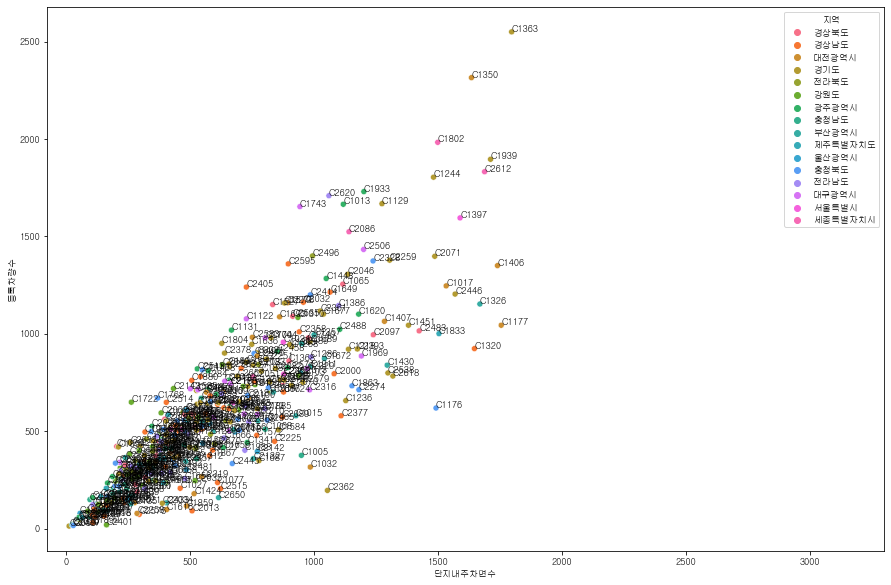

In [887]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='단지내주차면수', y='등록차량수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['단지내주차면수'][i], train_danji['등록차량수'][i]))
plt.xlim(right=3300)
plt.show()

In [888]:
train_danji.loc[train_danji['단지코드'] == 'C2362']

단지코드  총세대수   지역   공가수  지하철   버스  단지내주차면수  등록차량수
393  C2362  1500  경기도  46.0  0.0  2.0   1055.0  196.0

### 레그플롯_지역별(x=주차면수, y=등록차량수)

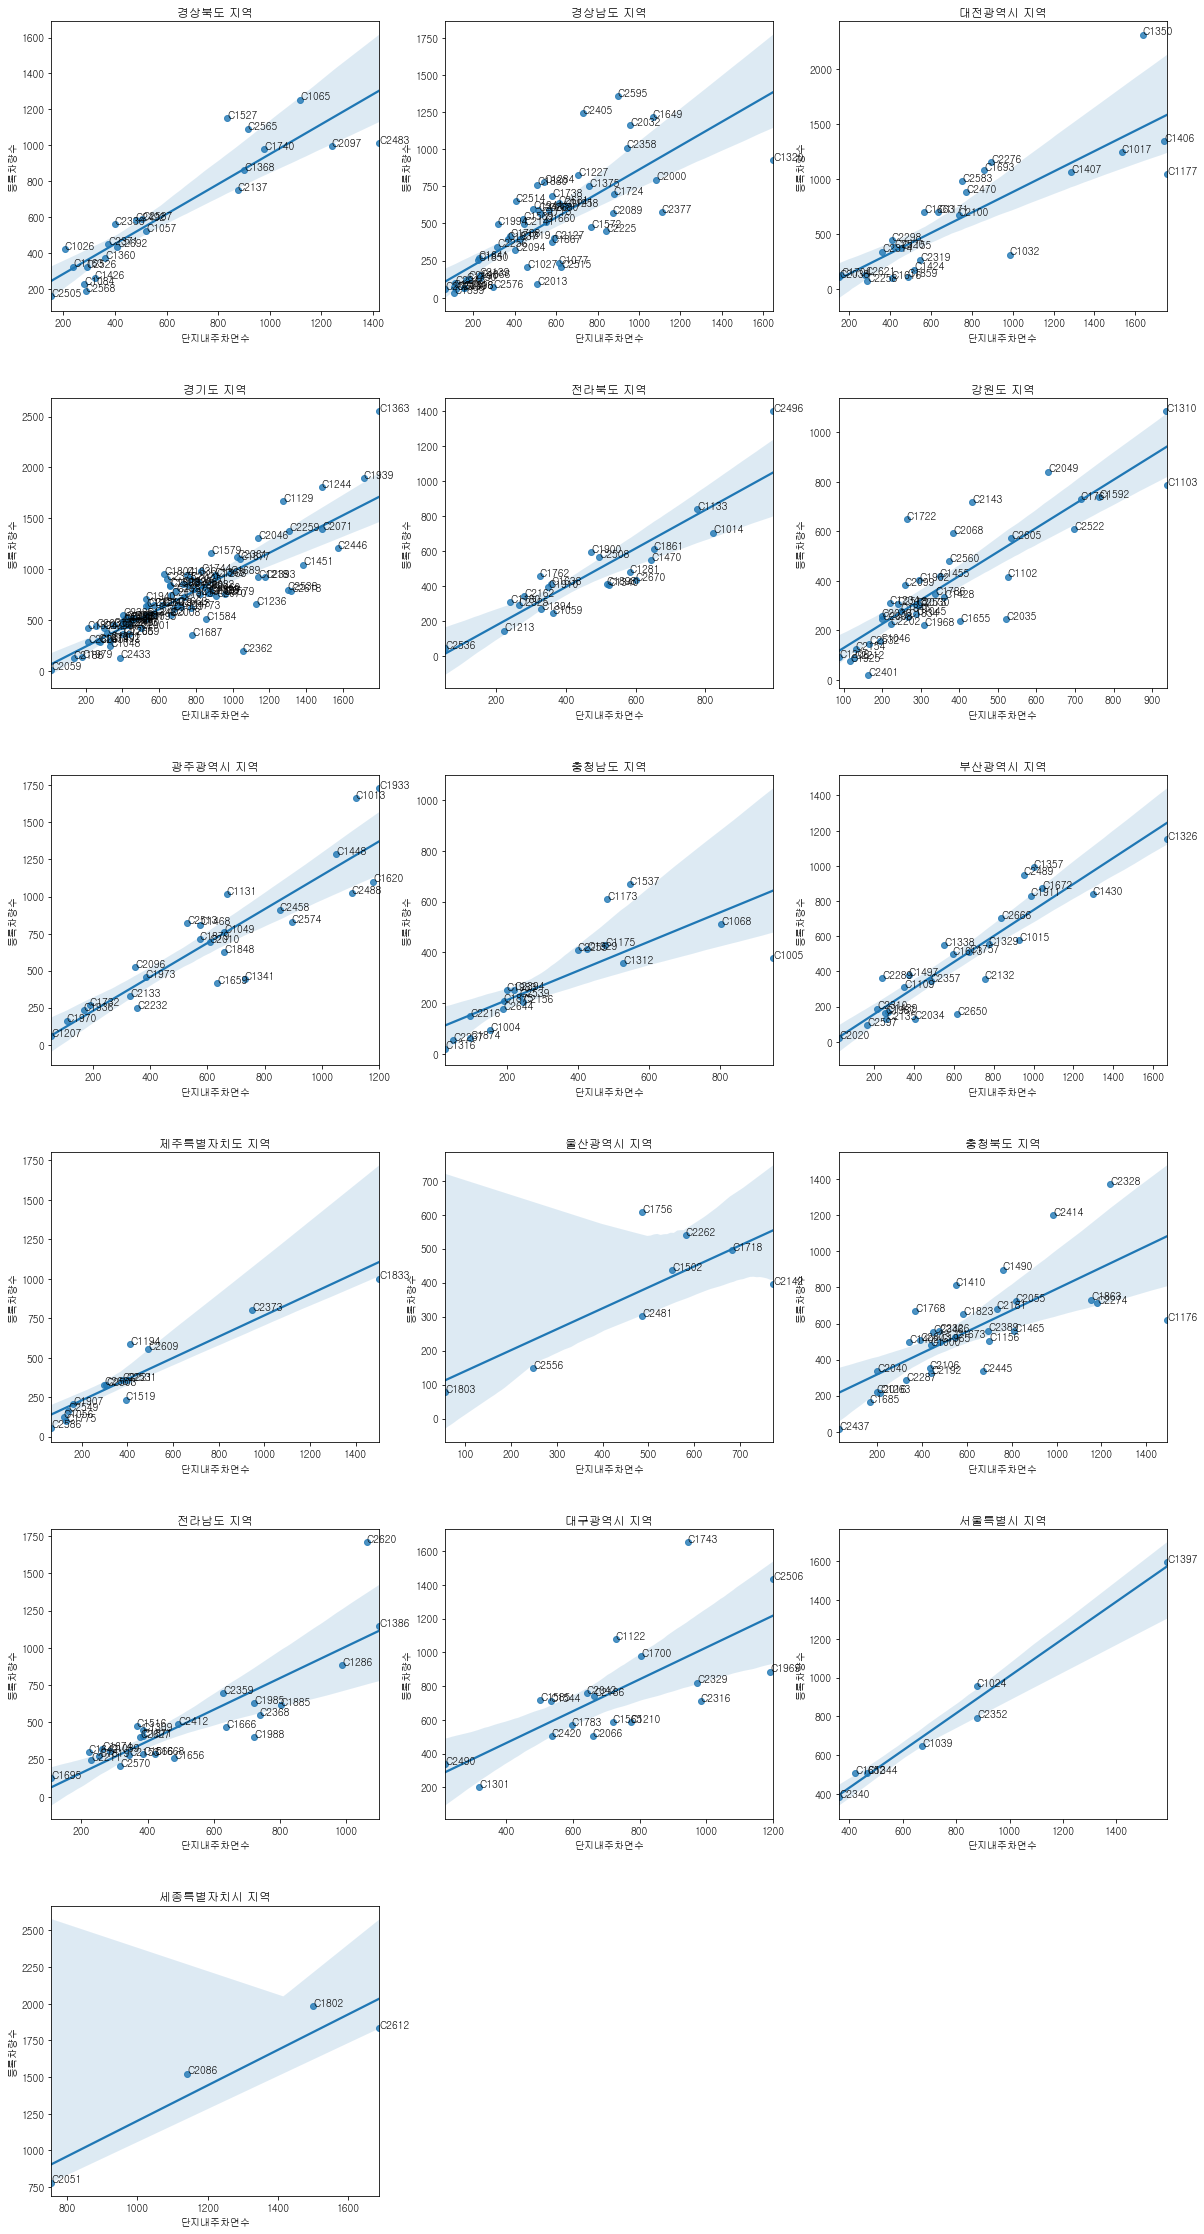

In [682]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='단지내주차면수', y='등록차량수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 산점도(x=총세대수, y=등록차량수)

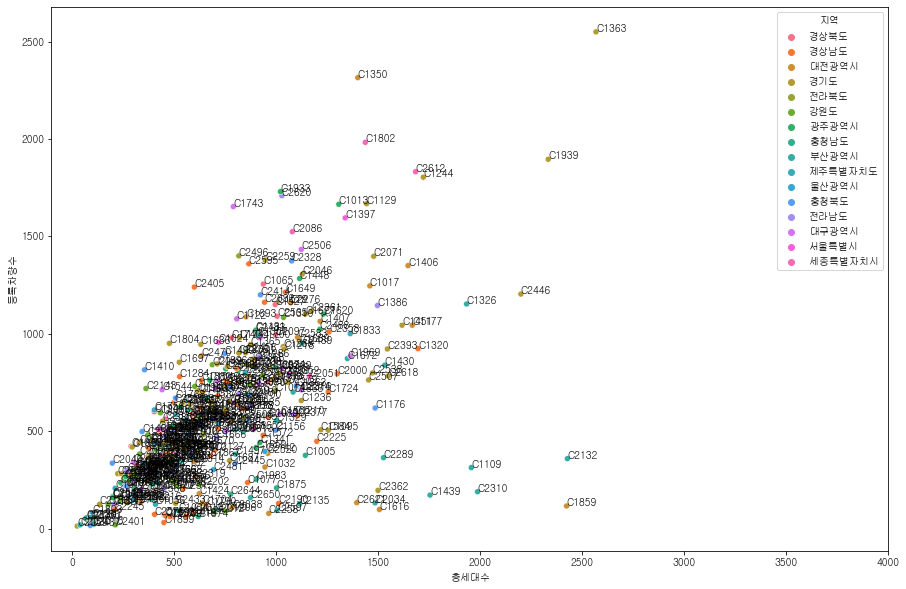

In [683]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='총세대수', y='등록차량수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['총세대수'][i], train_danji['등록차량수'][i]))
plt.xlim(right=4000)
plt.show()

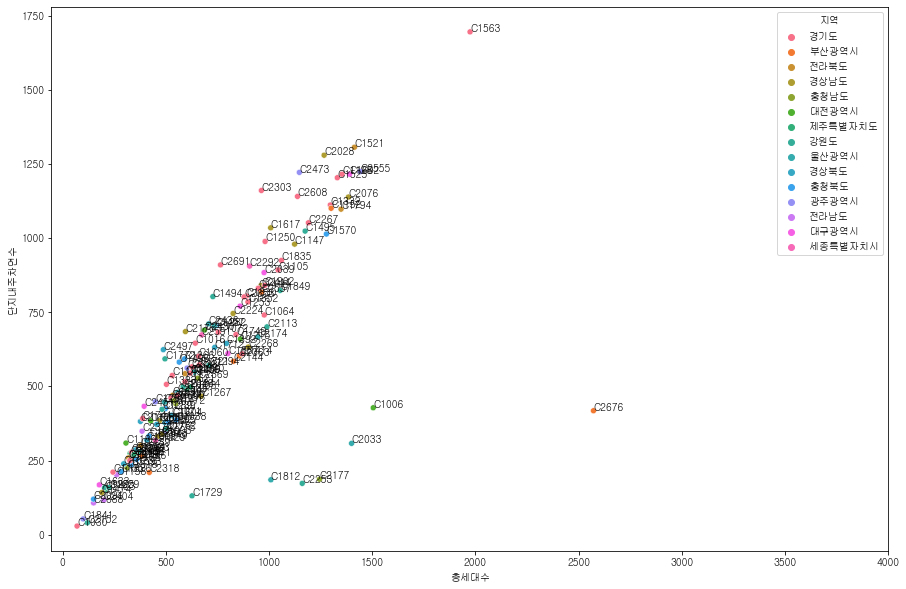

In [684]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_danji, x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_danji['단지코드']):
    plots.annotate(code, (test_danji['총세대수'][i], test_danji['단지내주차면수'][i]))
plt.xlim(right=4000)
plt.show()

### 레그플롯_지역별(x=총세대수, y=등록차량수)

지역별로 살펴봐야겠습니다. 지역별로 법정주차대수가 다르기 때문에 그래프가 다르게 나타날 수 있습니다.

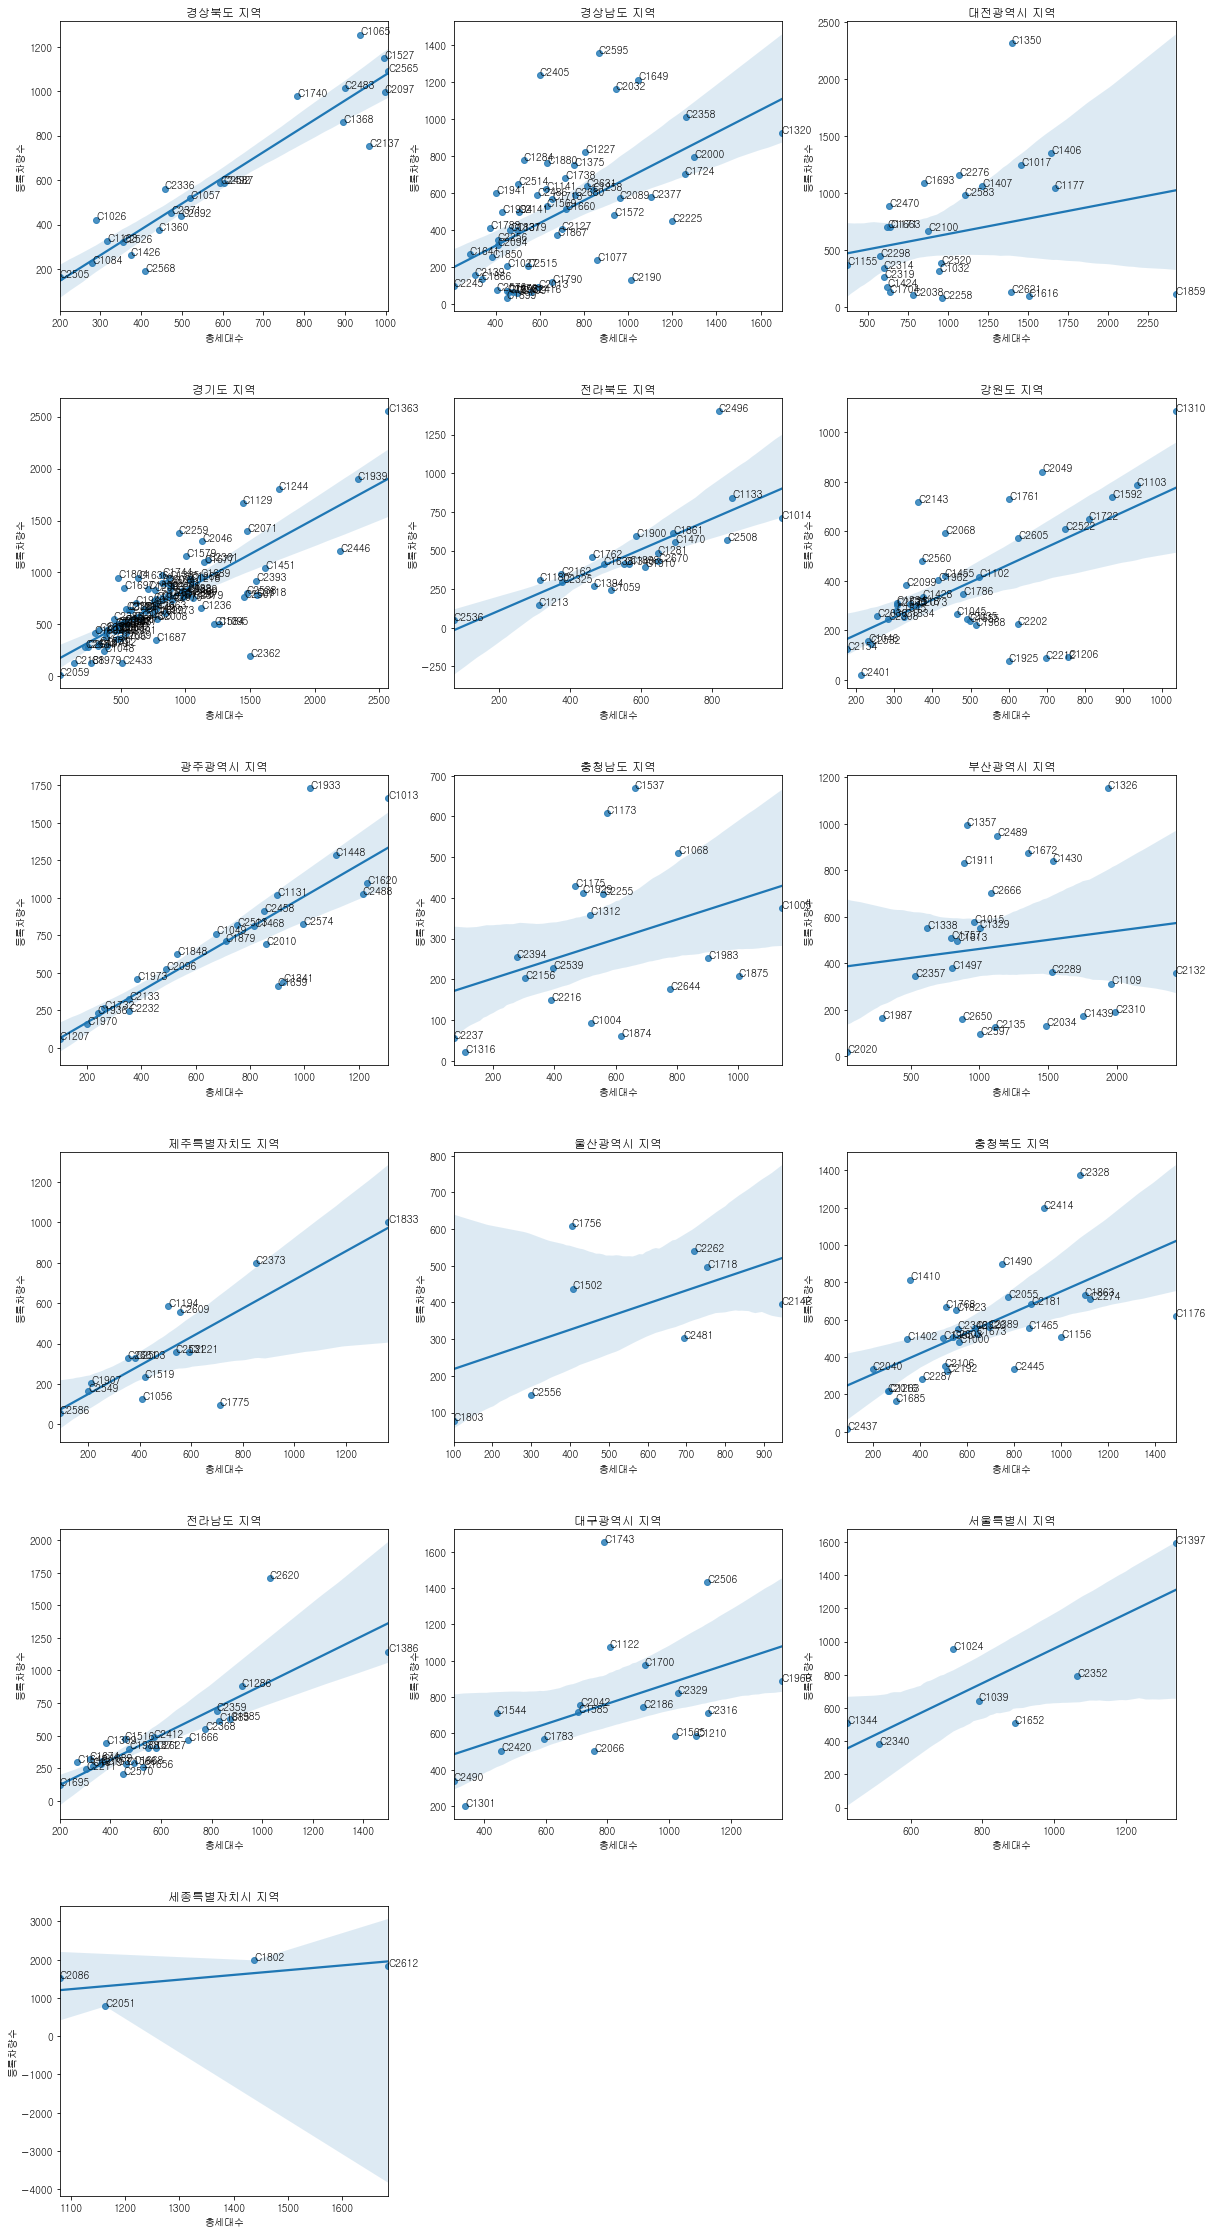

In [685]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='총세대수', y='등록차량수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['총세대수'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

- 보통은 법정주차대수 때문에 총세대수와 주차면수는 곧은 선형관계를 띄게 되어 있습니다.
- 그런데 우측 하단에 그 관계를 벗어나는 군집이 나타납니다. 대전, 강원도, 충남, 부산이 특히 그렇습니다.
- 가설은 아주 오래된 아파트이거나, 자차를 소유하지 않은 주민들이 많이 사는 지역일 가능성입니다.

### 산점도(x=건축연면적, y=등록차량수)

In [686]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [687]:
temp = train.groupby(['단지코드']).sum().reset_index()
train_size = pd.merge(train_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [688]:
temp = test.groupby(['단지코드']).sum().reset_index()
test_size = pd.merge(test_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

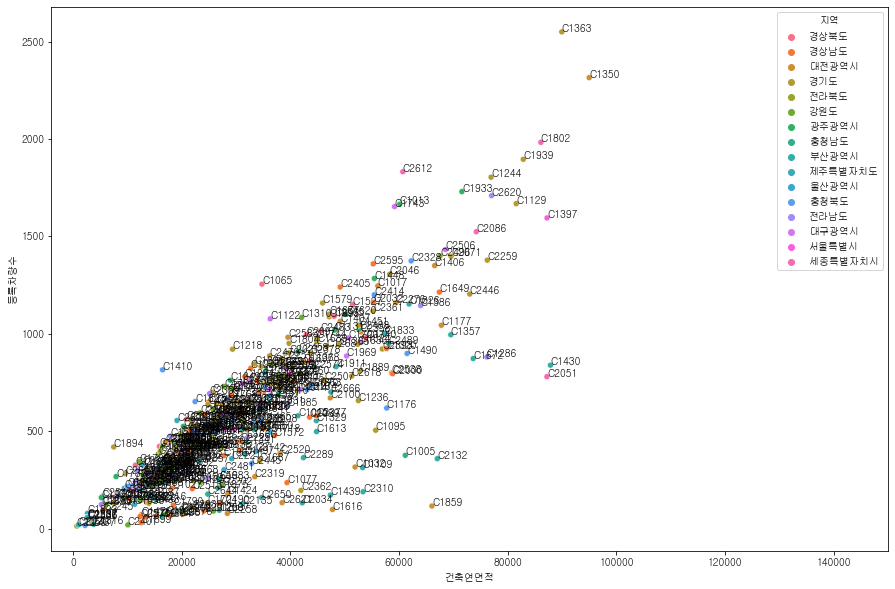

In [689]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_size, x='건축연면적', y='등록차량수', hue='지역')
for i, code in enumerate(train_size['단지코드']):
    plots.annotate(code, (train_size['건축연면적'][i], train_size['등록차량수'][i]))
plt.xlim(right=150000)
plt.show()

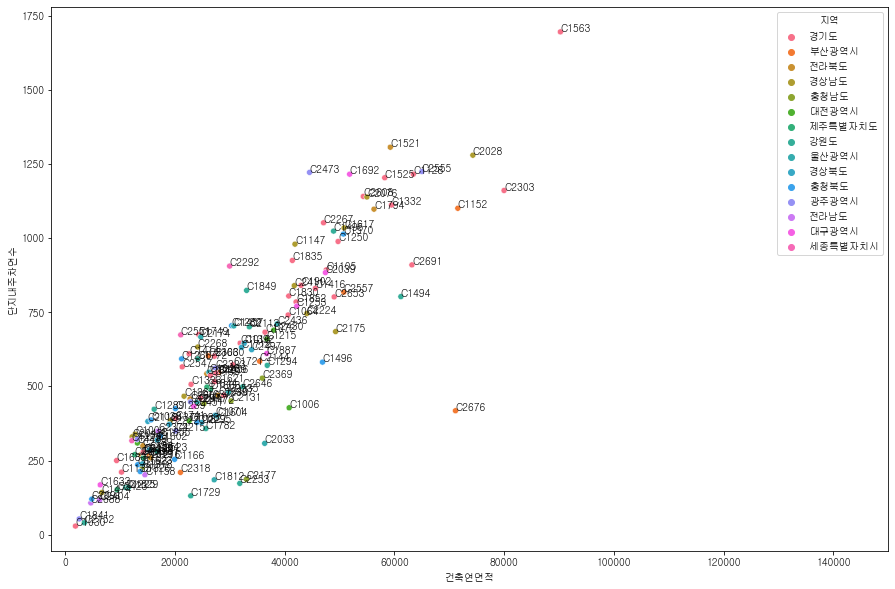

In [690]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_size, x='건축연면적', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_size['단지코드']):
    plots.annotate(code, (test_size['건축연면적'][i], test_size['단지내주차면수'][i]))
plt.xlim(right=150000)
plt.show()

건축연면적으로 따져도 추세선을 벗어나는 단지가 몇 개 있습니다.

### 레그플롯_지역별(x=건축연면적, y=등록차량수)

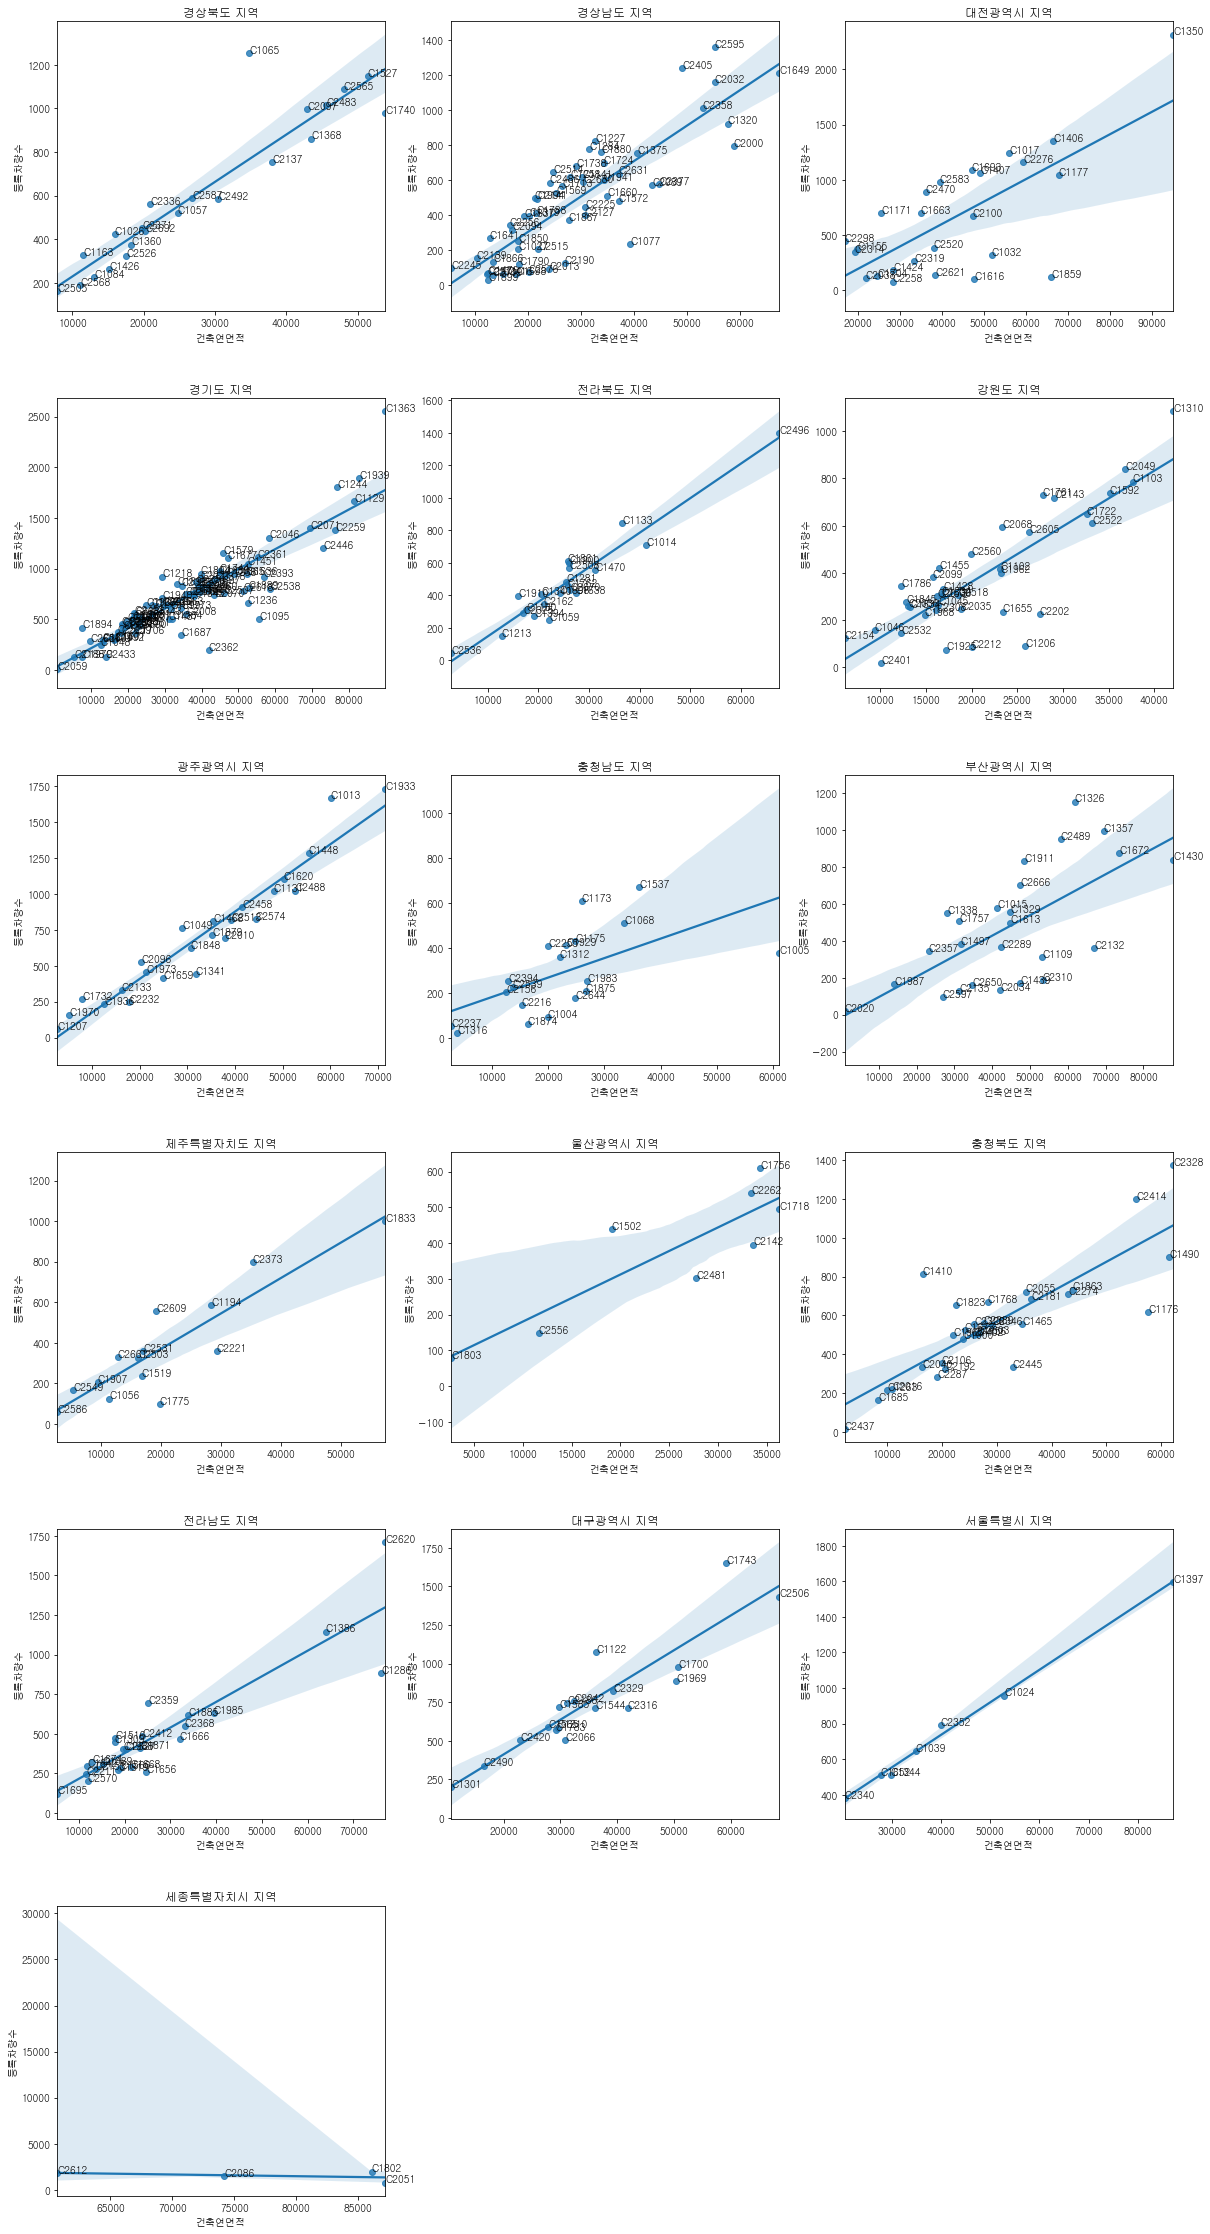

In [691]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_size.loc[train_size['지역'] == n], x='건축연면적', y='등록차량수')
    for i, code in enumerate(train_size.loc[train_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_size.loc[train_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              train_size.loc[train_size['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

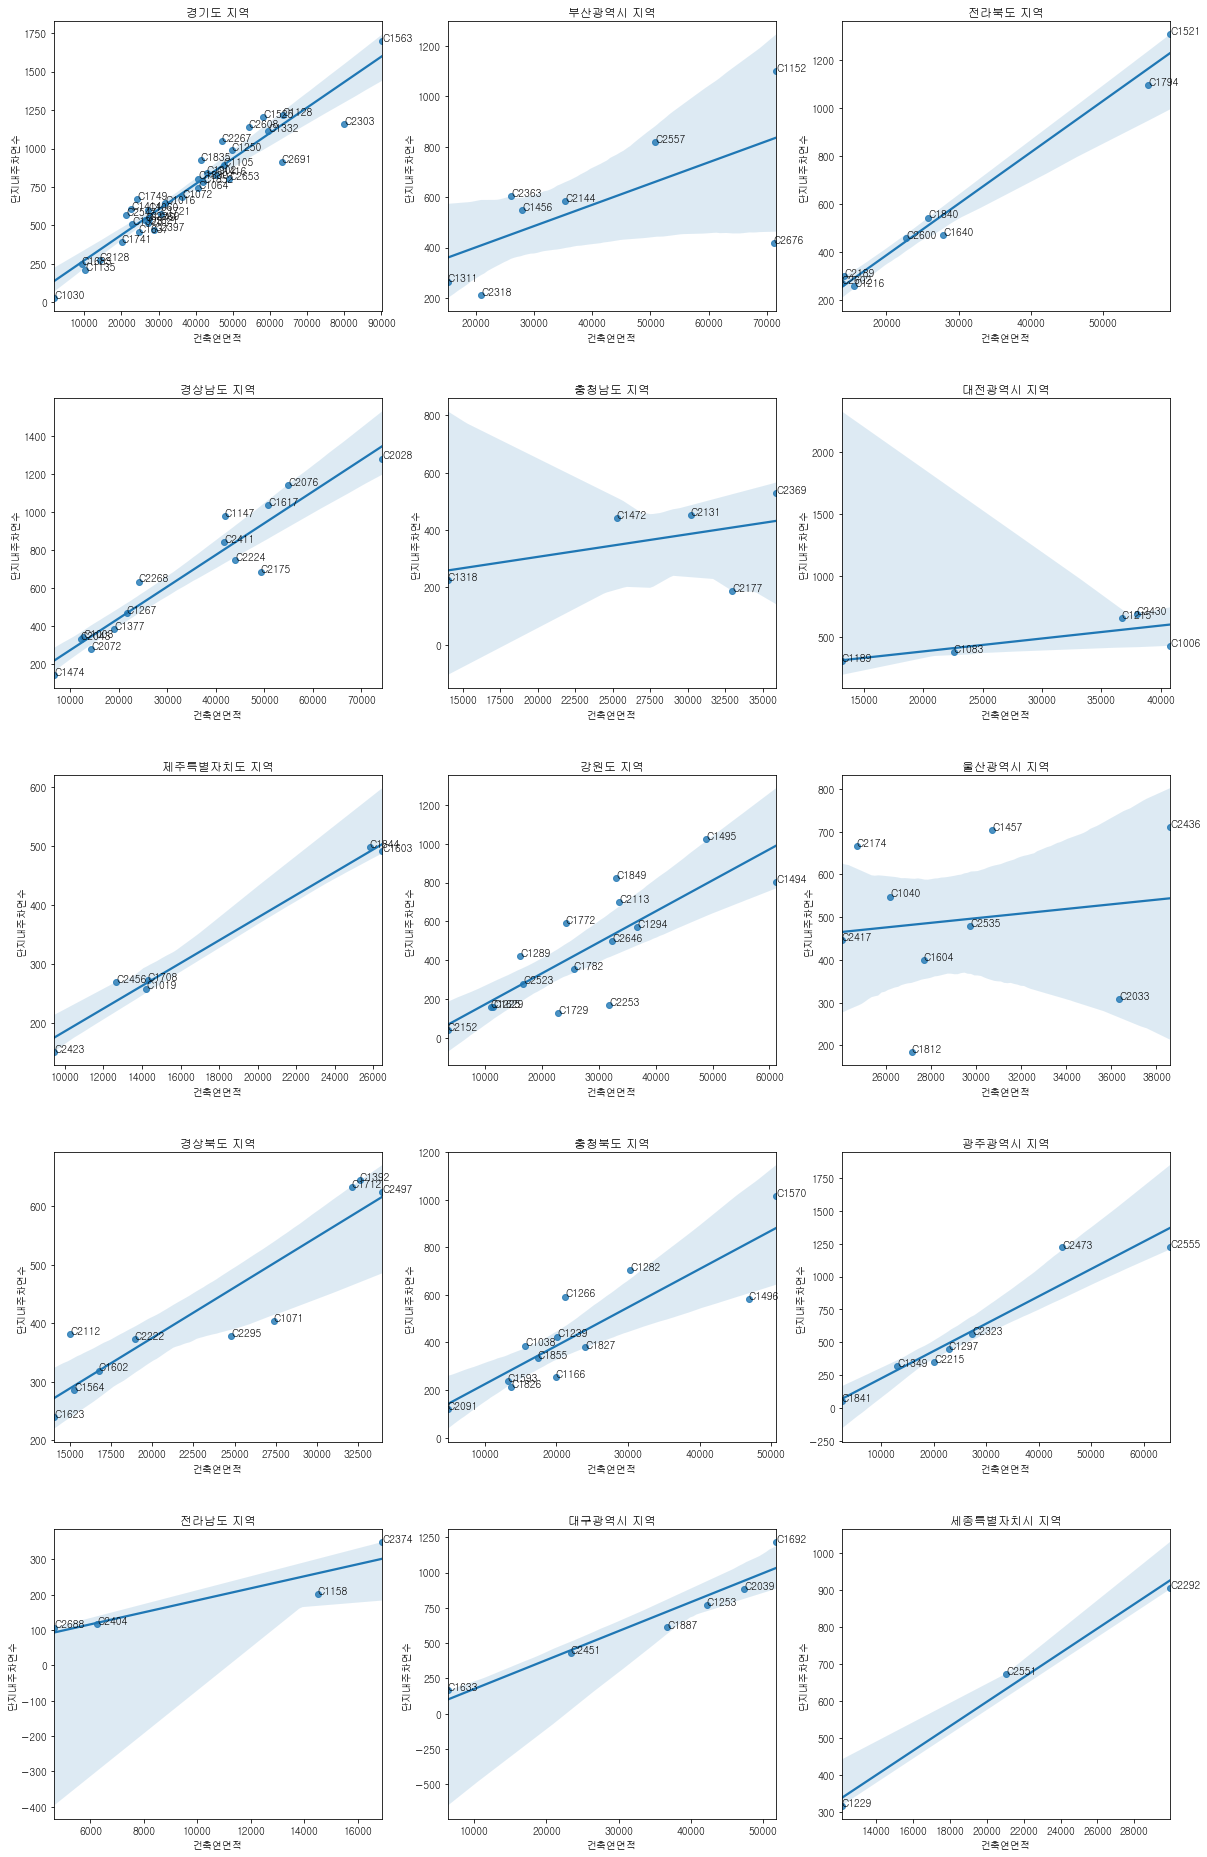

In [692]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=test_size.loc[test_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    for i, code in enumerate(test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (test_size.loc[test_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

근데 또 예측해야 하는 단지에 비율이 맞지 않는 단지들이 존재한다는 것이죠

### 바차트 (총세대수주차면수비 & 건축연면적주차면수비)

In [693]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/건축연면적'] = (train_size['등록차량수'] / train_size['건축연면적']) * 100

In [694]:
train_size.nlargest(5, '등록차량수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수     건축연면적  \
196  C1410   356   충청북도  10.0  0.0  3.0    550.0   815.0  16485.44   
318  C1743   791  대구광역시  16.0  1.0  1.0    944.0  1653.0  59167.83   
300  C2405   600   경상남도  22.0  0.0  8.0    728.0  1240.0  49163.00   
272  C1804   478    경기도   3.0  0.0  3.0    629.0   951.0  39754.25   
359  C2143   363    강원도   2.0  0.0  2.0    434.0   719.0  29048.58   

     등록차량수/총세대수  등록차량수/건축연면적  
196    2.289326     4.943756  
318    2.089760     2.793748  
300    2.066667     2.522222  
272    1.989540     2.392197  
359    1.980716     2.475164

In [695]:
train_size.nsmallest(5, '등록차량수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수  등록차량수     건축연면적  등록차량수/총세대수  \
30  C1859  2424  대전광역시   1.0  1.0  4.0    487.0  116.0  66049.65    0.047855   
25  C1616  1507  대전광역시   1.0  0.0  2.0    407.0   98.0  47743.56    0.065030   
50  C1899   451   경상남도   0.0  0.0  4.0    109.0   31.0  12524.94    0.068736   
27  C2258   965  대전광역시  13.0  0.0  3.0    287.0   78.0  28400.76    0.080829   
39  C2034  1486  부산광역시   2.0  1.0  3.0    405.0  132.0  42187.95    0.088829   

    등록차량수/건축연면적  
30     0.175625  
25     0.205263  
50     0.247506  
27     0.274641  
39     0.312886

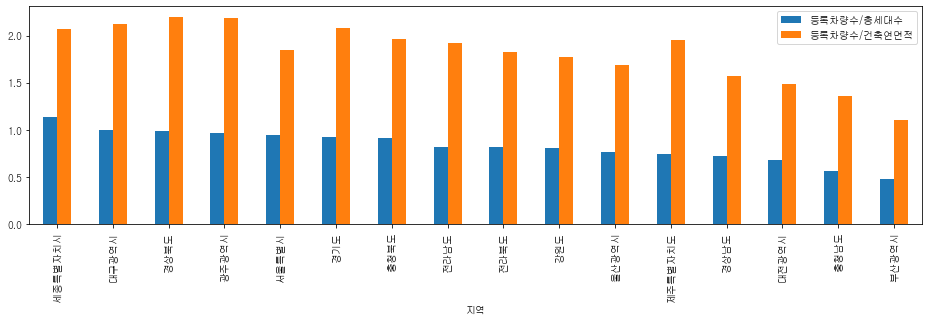

In [696]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/건축연면적']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

- 두 비가 다 높은 서울시는 주어진 총세대수와 건축연면적에 비해 주차면수가 높게 형성되어 있다는 뜻입니다.
- 세종은 총세대수에 대한 주차면수는 높지만, 건축연면적에 비해서는 낮습니다.
- 보통 총세대수가 많으면 건축연면적도 높습니다. 그래서 비율이 비슷하게 가는 것이 보통입니다.
- 세종같은 경우는 총세대수에 비해 건축연면적이 높은 편이라는 뜻이고, 이는 대형평형수가 많다는 의미입니다.
- 총세대수주차면수비에 비해 건축연면적주차면수비가 높은 경기도 같은 경우는 반대라는 것입니다.

In [697]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/건축연면적'] = (train_size['등록차량수'] / train_size['건축연면적']) * 50
train_size['등록차량수/주차면수'] = train_size['등록차량수'] / train_size['단지내주차면수']

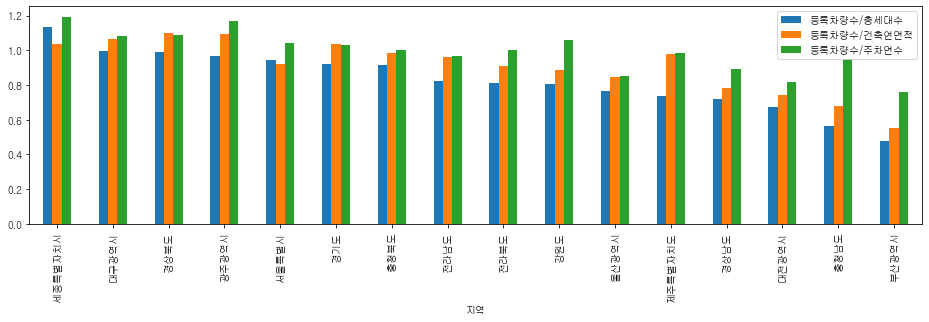

In [698]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/건축연면적', '등록차량수/주차면수']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

### 공급유형 바차트

공급유형을 살펴봐야겠습니다.

In [699]:
train_reqruit = pd.pivot_table(train, index='단지코드', columns='공급유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_reqruit.head()

공급유형   공공임대(10년)  공공임대(50년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택
단지코드                                                         
C1000          0          0         0   566     0     0     0
C1004          0          0         0     0   504     0     0
C1005          0          0         0  1144     0     0     0
C1013          0          0         0  1308     0     0     0
C1014          0          0         0   996     0     0     0

In [700]:
train_reqruit2 = pd.merge(train_reqruit.reset_index(), train[['단지코드', '지역', '등록차량수']],
                          how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

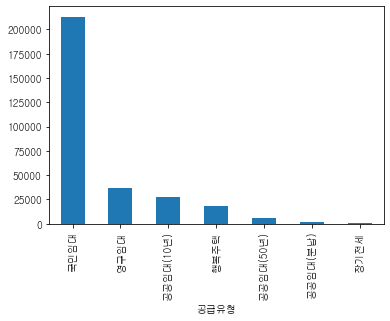

In [701]:
train_reqruit.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- 국민임대가 20만호가 넘으며 압도적인 비중입니다. 그 뒤로 영구임대, 공공임대, 행복주택 등이 있습니다.

In [702]:
test['공급유형'].unique()

array(['국민임대', '영구임대', '공공임대(50년)', '공공임대(10년)', '공공임대(분납)', '행복주택'],
      dtype=object)

In [703]:
train_reqruit2.nlargest(10, '공공임대(10년)')

공공임대(10년)  공공임대(50년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택       지역   등록차량수
단지코드                                                                          
C1129       1444          0         0     0     0     0     0      경기도  1668.0
C1802       1438          0         0     0     0     0     0  세종특별자치시  1983.0
C2051       1164          0         0     0     0     0     0  세종특별자치시   780.0
C2506       1124          0         0     0     0     0     0    대구광역시  1433.0
C2086       1080          0         0     0     0     0     0  세종특별자치시  1524.0
C2328       1077          0         0     0     0     0     0     충청북도  1374.0
C2620       1029          0         0     0     0     0     0     전라남도  1709.0
C1933       1022          0         0     0     0     0     0    광주광역시  1730.0
C2259        947          0         0     0     0     0     0      경기도  1378.0
C2414        924          0         0     0     0     0     0     충청북도  1200.0

In [704]:
train_reqruit2.nlargest(10, '공공임대(50년)')

공공임대(10년)  공공임대(50년)  공공임대(분납)  국민임대  영구임대  장기전세  행복주택       지역  등록차량수
단지코드                                                                         
C2520          0        960         0     0     0     0     0    대전광역시  386.0
C1497          0        802         0     0     0     0     0    부산광역시  382.0
C1424          0        624         0     0     0     0     0    대전광역시  179.0
C2202          0        623         0     0     0     0     0      강원도  226.0
C2221          0        590         0     0     0     0     0  제주특별자치도  359.0
C2340          0        512         0     0     0     0     0    서울특별시  382.0
C1722          0        505         0     0   298     0     0      강원도  649.0
C2216          0        390         0     0     0     0     0     충청남도  149.0
C2644          0        387         0     0   388     0     0     충청남도  177.0
C1850          0        385         0     0     0     0     0     경상남도  254.0

In [708]:
req_cols = ['공공임대(10년)', '공공임대(50년)', '공공임대(분납)',
       '영구임대', '장기전세', '행복주택']

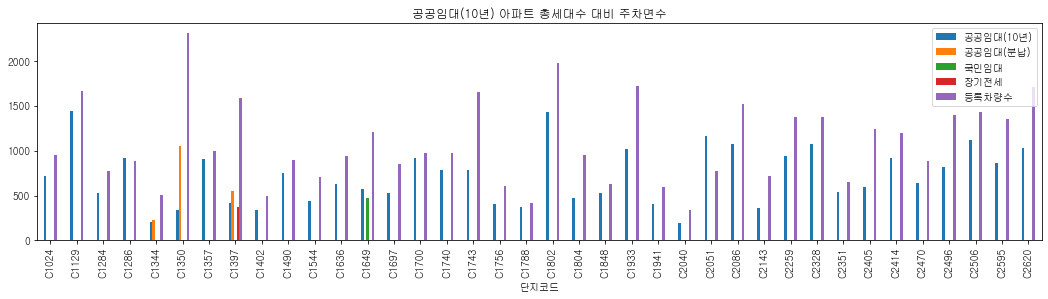

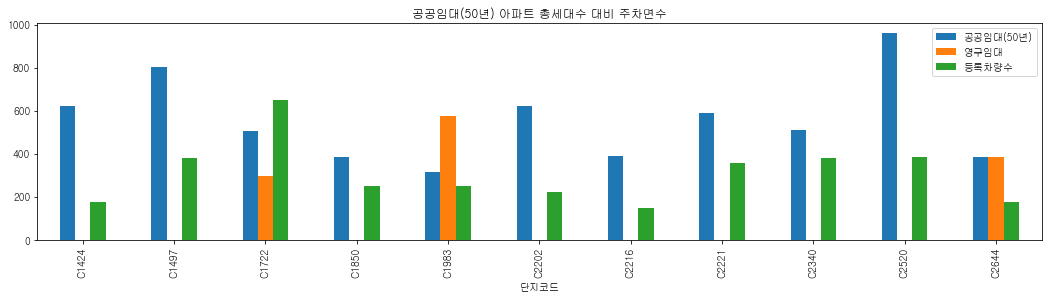

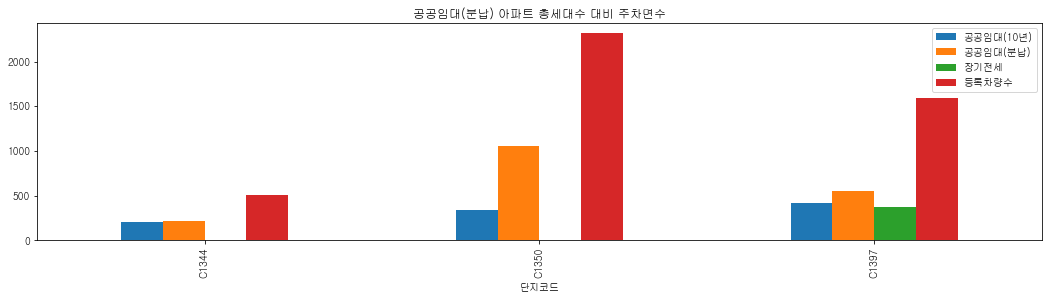

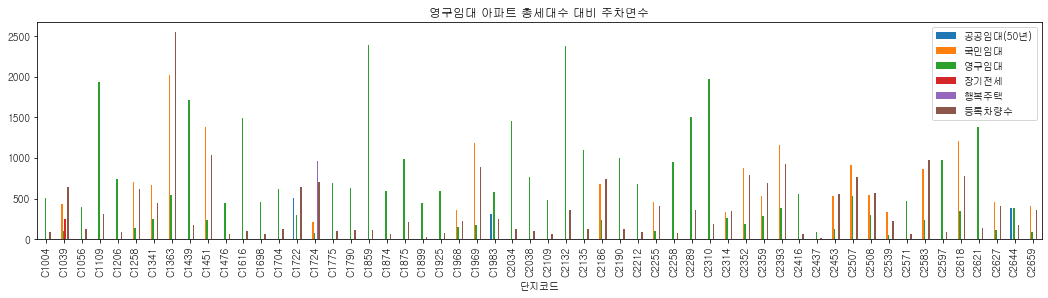

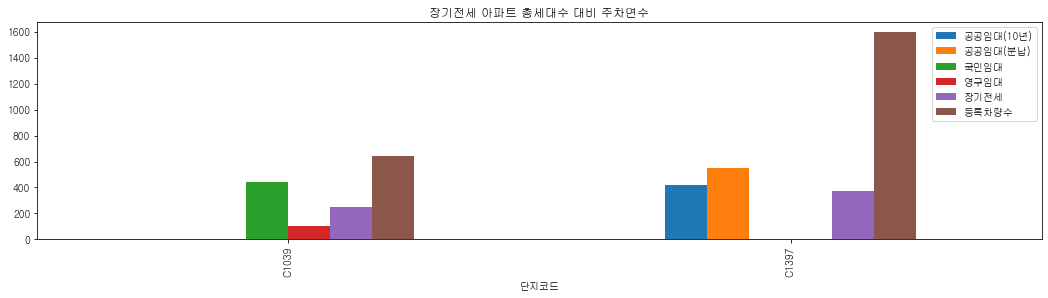

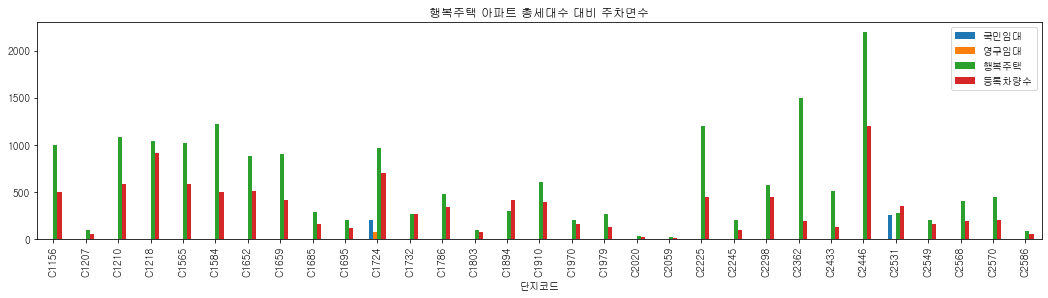

In [709]:
for col in req_cols:
    train_reqruit2.loc[train_reqruit2[col] != 0,
                      [x for x in train_reqruit2.columns if train_reqruit2.loc[train_reqruit2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 주차면수'.format(col))
    plt.show()

- 특이한 점이 많습니다.
1. 임대상가가 있는 아파트는 무조건 영구임대단지다. 총세대수에 비해 주차면수도 굉장히 적다.
2. 공공임대(50년)이 있는 단지는 주차면수가 총세대수에 비해 굉장히 적다.
3. 행복주택은 보통 행복주택만 있습니다.
4. 공공분양, 공공임대(5년), 장기전세는 단지가 너무 없습니다.

### 자격유형 바차트

In [712]:
train_qual = pd.pivot_table(train, index='단지코드', columns='자격유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_qual.head()

자격유형      A  B    C  E  F  G  H  I  J  K  L  M  N  O
단지코드                                                
C1000   566  0    0  0  0  0  0  0  0  0  0  0  0  0
C1004     0  0  504  0  0  0  0  0  0  0  0  0  0  0
C1005  1144  0    0  0  0  0  0  0  0  0  0  0  0  0
C1013  1308  0    0  0  0  0  0  0  0  0  0  0  0  0
C1014   996  0    0  0  0  0  0  0  0  0  0  0  0  0

In [713]:
train_qual2 = pd.merge(train_qual.reset_index(),
                       train[['단지코드', '지역', '등록차량수']],
                       how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

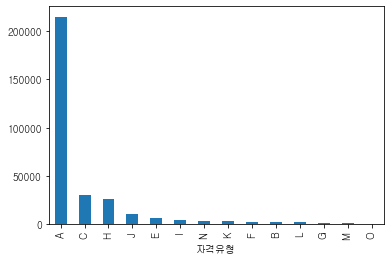

In [714]:
train_qual.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- A가 압도적으로 많습니다. C, H가 뒤를 잇습니다.

In [718]:
qual_cols = ['C', 'E', 'H', 'I', 'J', 'K', 'L']
qual_cols2 = ['M', 'N', 'O', 'F', 'B', 'G']

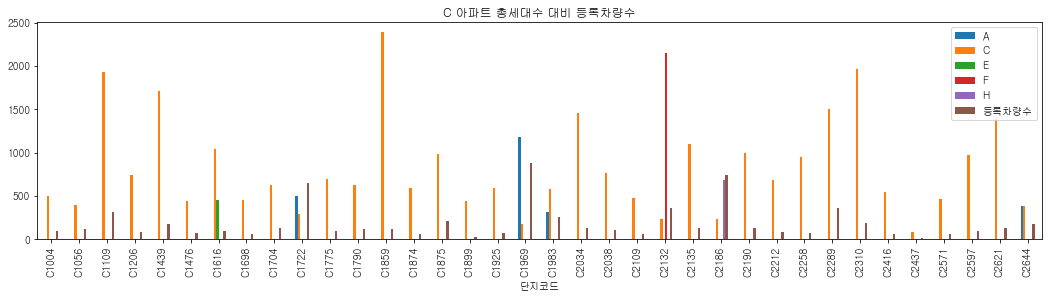

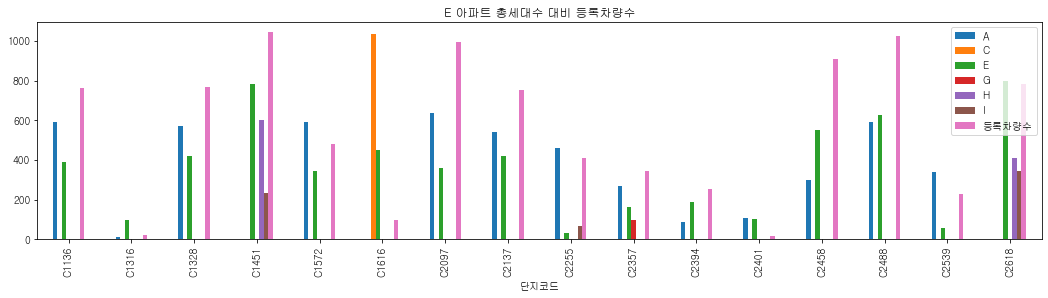

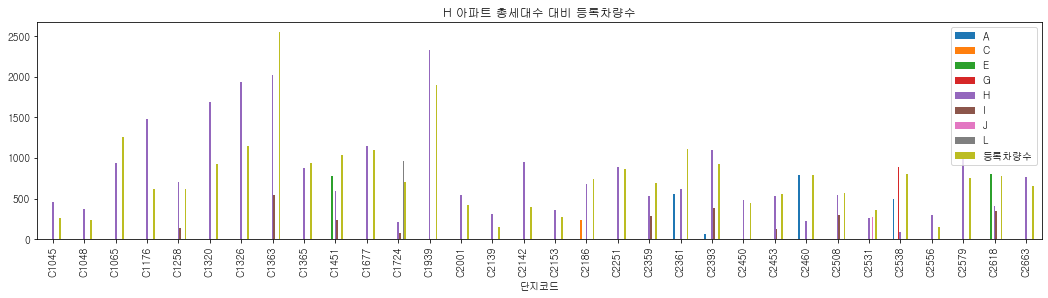

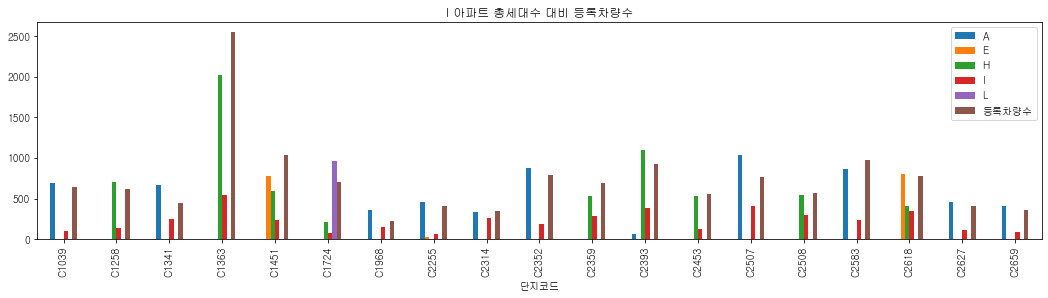

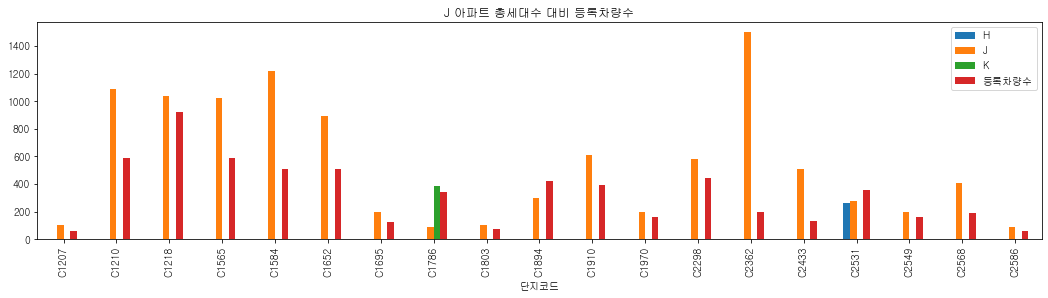

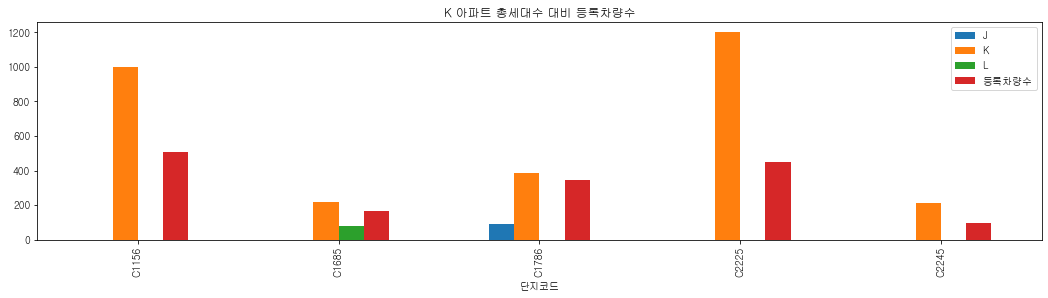

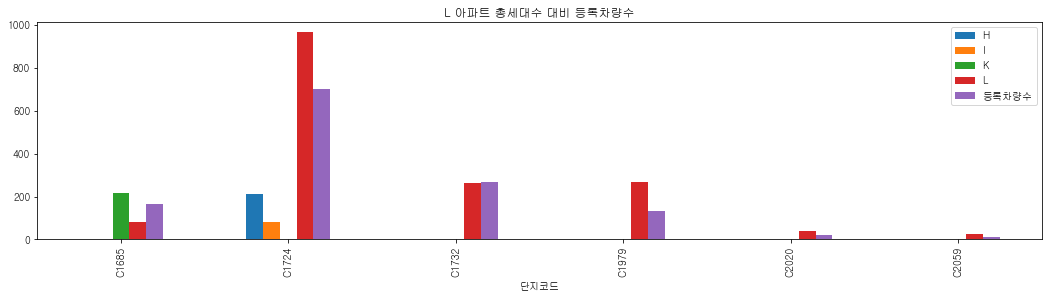

In [719]:
for col in qual_cols:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 등록차량수'.format(col))
    plt.show()

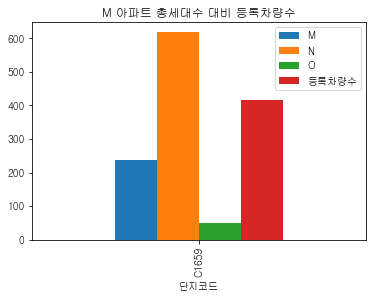

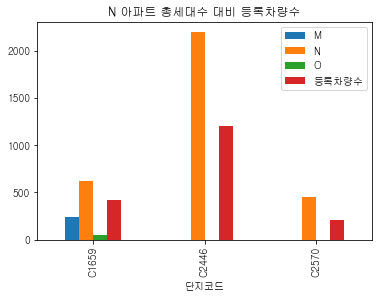

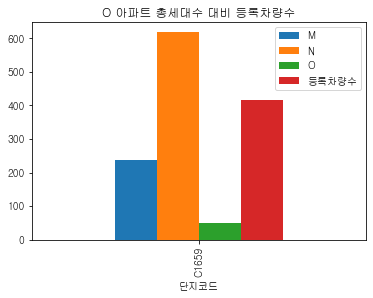

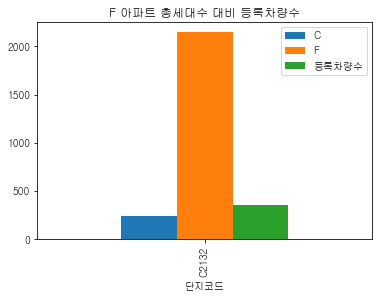

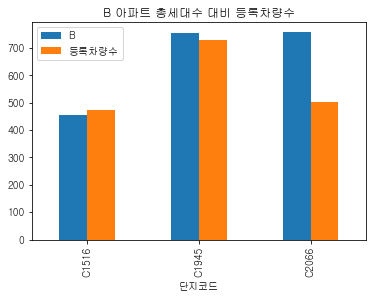

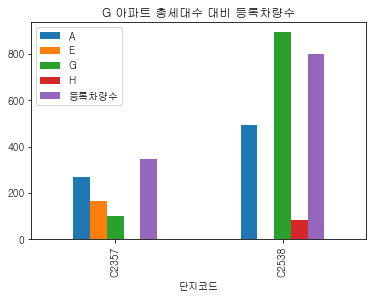

In [720]:
for col in qual_cols2:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(6, 4))
    plt.title('{} 아파트 총세대수 대비 등록차량수'.format(col))
    plt.show()

In [721]:
train_req_qual = pd.merge(train_qual, train_reqruit2.reset_index(), how='inner', on='단지코드').drop_duplicates().set_index('단지코드')
train_req_qual.head()

A  B    C  E  F  G  H  I  J  K  L  M  N  O  공공임대(10년)  공공임대(50년)  \
단지코드                                                                         
C1000   566  0    0  0  0  0  0  0  0  0  0  0  0  0          0          0   
C1004     0  0  504  0  0  0  0  0  0  0  0  0  0  0          0          0   
C1005  1144  0    0  0  0  0  0  0  0  0  0  0  0  0          0          0   
C1013  1308  0    0  0  0  0  0  0  0  0  0  0  0  0          0          0   
C1014   996  0    0  0  0  0  0  0  0  0  0  0  0  0          0          0   

       공공임대(분납)  국민임대  영구임대  장기전세  행복주택     지역   등록차량수  
단지코드                                                    
C1000         0   566     0     0     0   충청북도   481.0  
C1004         0     0   504     0     0   충청남도    93.0  
C1005         0  1144     0     0     0   충청남도   376.0  
C1013         0  1308     0     0     0  광주광역시  1665.0  
C1014         0   996     0     0     0   전라북도   708.0

In [722]:
for col in req_cols:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

공공임대(10년)
+------------+------+------------------+------------------+------------+------------+----------------+--------------+
| 단지코드   |    A |   공공임대(10년) |   공공임대(분납) |   국민임대 |   장기전세 | 지역           |   등록차량수 |
|------------+------+------------------+------------------+------------+------------+----------------+--------------|
| C1024      |  718 |              718 |                0 |          0 |          0 | 서울특별시     |          957 |
| C1129      | 1444 |             1444 |                0 |          0 |          0 | 경기도         |         1668 |
| C1284      |  528 |              528 |                0 |          0 |          0 | 경상남도       |          780 |
| C1286      |  919 |              919 |                0 |          0 |          0 | 전라남도       |          881 |
| C1344      |  424 |              202 |              222 |          0 |          0 | 서울특별시     |          509 |
| C1350      | 1401 |              342 |             1059 |          0 |          0 | 대전광역시     |

In [724]:
for col in ['B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

B
+------------+-----+------------+------------+--------------+
| 단지코드   |   B |   국민임대 | 지역       |   등록차량수 |
|------------+-----+------------+------------+--------------|
| C1516      | 456 |        456 | 전라남도   |          475 |
| C1945      | 755 |        755 | 경기도     |          730 |
| C2066      | 757 |        757 | 대구광역시 |          503 |
+------------+-----+------------+------------+--------------+

C
+------------+------+------+-----+------+-----+------------------+------------+------------+----------------+--------------+
| 단지코드   |    A |    C |   E |    F |   H |   공공임대(50년) |   국민임대 |   영구임대 | 지역           |   등록차량수 |
|------------+------+------+-----+------+-----+------------------+------------+------------+----------------+--------------|
| C1004      |    0 |  504 |   0 |    0 |   0 |                0 |          0 |        504 | 충청남도       |           93 |
| C1056      |    0 |  400 |   0 |    0 |   0 |                0 |          0 |        400 | 제주특별자치도 |          125 

### 지역별 자격유형별 평균 임대료

In [725]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [726]:
mean_rent = mean_rent.loc[mean_rent['면적당임대료'] != 0]

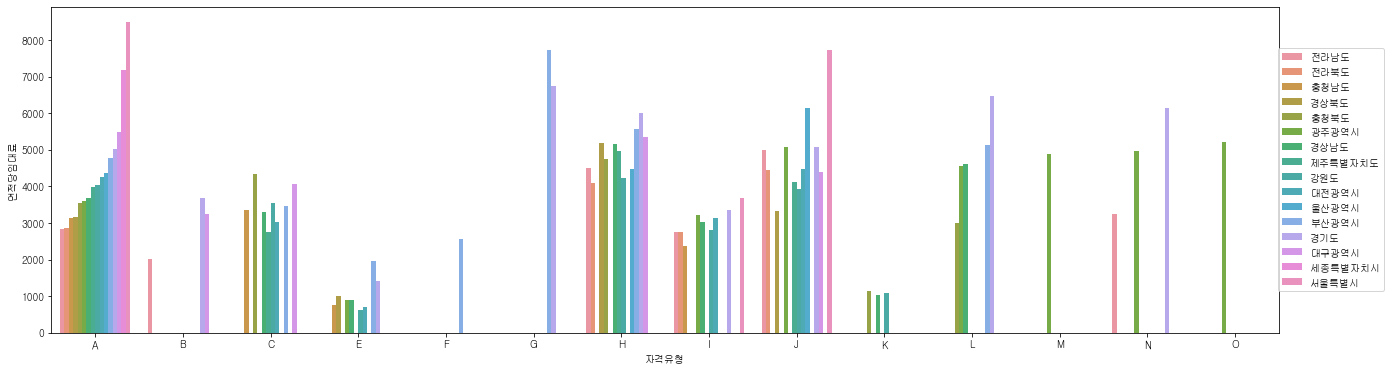

In [727]:
plt.figure(figsize=(22, 6))
sns.barplot(data=mean_rent.sort_values(by=['자격유형', '면적당임대료']),
            x='자격유형', y='면적당임대료', hue='지역')
plt.legend(loc='right', bbox_to_anchor=(1.09, 0.5))
plt.show()

- A, J, G 는 꽤나 높게 형성됩니다.
- 그러나 E, K 는 꽤나 낮게 형성됩니다.

In [728]:
kookmin_A = (
    train
    .loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'A')]
    .groupby(['지역'])['면적당임대료']
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
kookmin_A

면적당임대료
지역                  
서울특별시    7487.593573
세종특별자치시  5321.380731
경기도      4856.416305
부산광역시    4641.213217
대구광역시    4272.213051
대전광역시    4084.761630
강원도      3940.679162
제주특별자치도  3787.516145
울산광역시    3574.029464
경상남도     3354.302561
충청북도     3103.855208
광주광역시    3058.832986
충청남도     3032.201320
경상북도     3028.435011
전라북도     2688.863480
전라남도     2534.966167

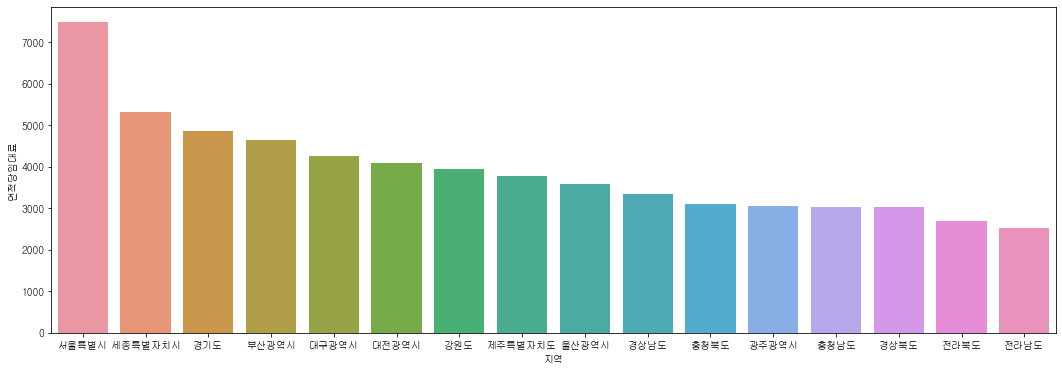

In [729]:
plt.figure(figsize=(18, 6))
sns.barplot(data=kookmin_A, x=kookmin_A.index, y='면적당임대료')
plt.show()

- 국민임대일반지수를 만들어줄 수도 있을 것 같습니다. 표준화를 통해서..
- 지역별 국민임대, A 의 평균 면적당 임대료를 수치로 넣어주면, 해당 지역의 보통의 지가의 수치를 대변할 수 있을 것도 같습니다.
- 문제는 강원도가 상당히 높은 게 이상합니다.

In [730]:
mean_ = kookmin_A['면적당임대료'].mean()
std_ = kookmin_A['면적당임대료'].std()
kookmin_A['국민임대일반지수'] = (kookmin_A['면적당임대료'] - mean_) / std_

In [731]:
kookmin_A

면적당임대료  국민임대일반지수
지역                            
서울특별시    7487.593573  2.871092
세종특별자치시  5321.380731  1.126345
경기도      4856.416305  0.751845
부산광역시    4641.213217  0.578513
대구광역시    4272.213051  0.281306
대전광역시    4084.761630  0.130326
강원도      3940.679162  0.014277
제주특별자치도  3787.516145 -0.109086
울산광역시    3574.029464 -0.281036
경상남도     3354.302561 -0.458013
충청북도     3103.855208 -0.659732
광주광역시    3058.832986 -0.695995
충청남도     3032.201320 -0.717445
경상북도     3028.435011 -0.720478
전라북도     2688.863480 -0.993982
전라남도     2534.966167 -1.117936

In [732]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [733]:
# 자격유형이 존재하지 않는 지역이 있는데, 0 으로 동일하게 넣어주겠습니다. 원활한 시각화를 위해.
for region in list(mean_rent['지역'].unique()):
    for qual in list(mean_rent['자격유형'].unique()):
        if len(mean_rent.loc[(mean_rent['지역'] == region) & (mean_rent['자격유형'] == qual)]) == 0:
            mean_rent = mean_rent.append({'지역': region, '자격유형': qual, '면적당임대료': 0}, ignore_index=True)
        else:
            pass

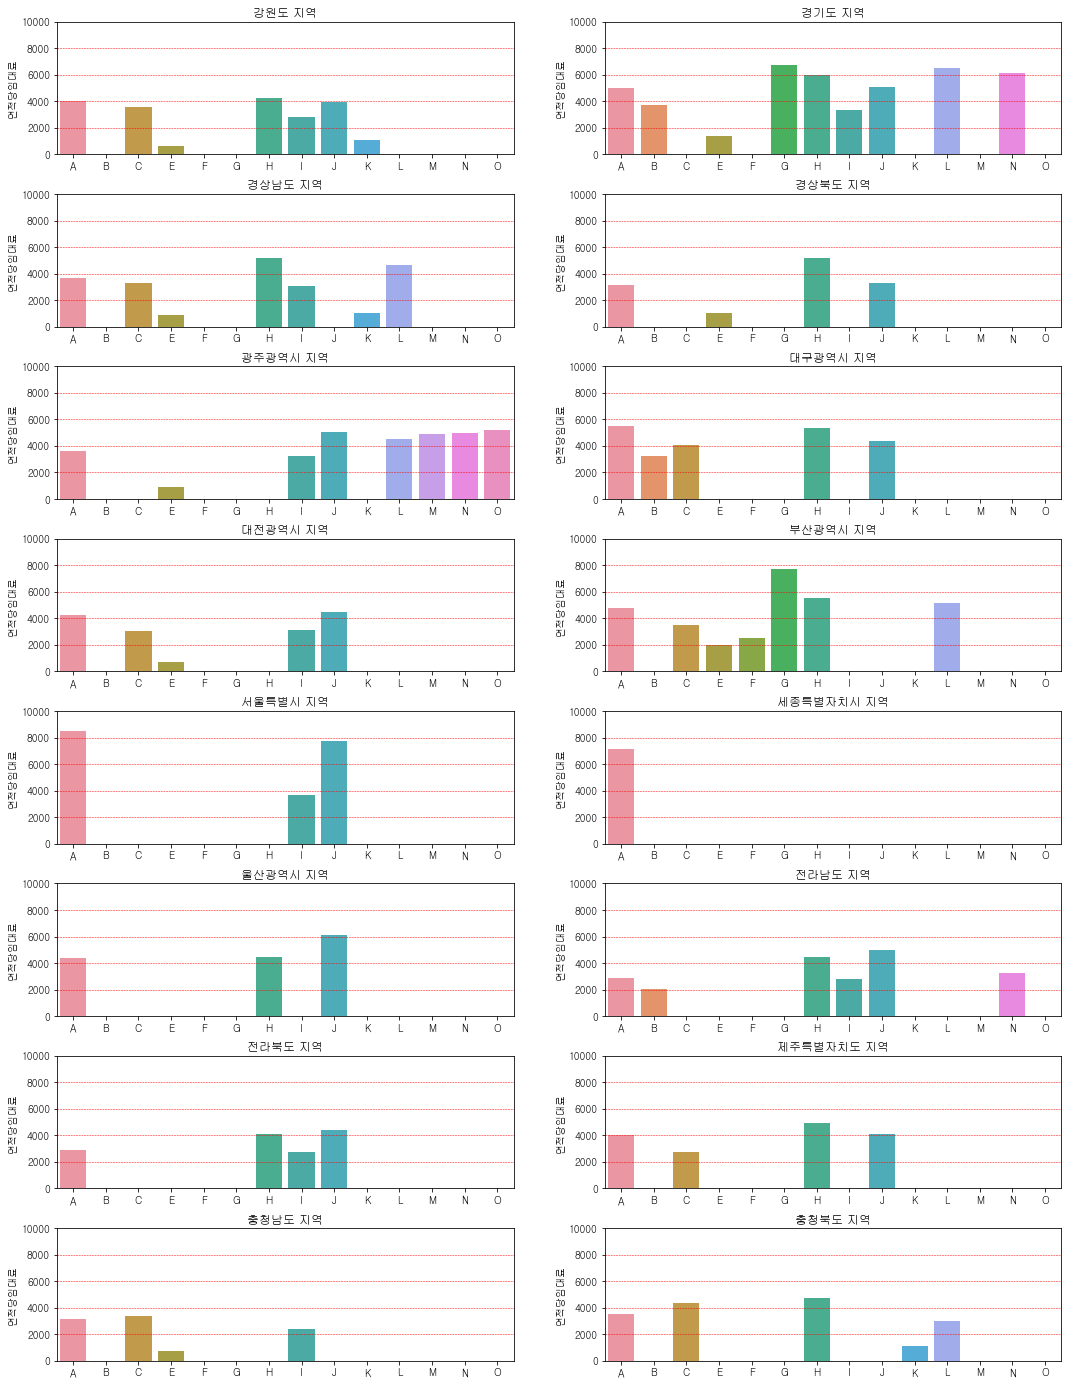

In [734]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(list(mean_rent['지역'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['지역'] == n].sort_values('자격유형'), x='자격유형', y='면적당임대료')
    plt.ylim(top = 10000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 8000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.title('{} 지역'.format(n))

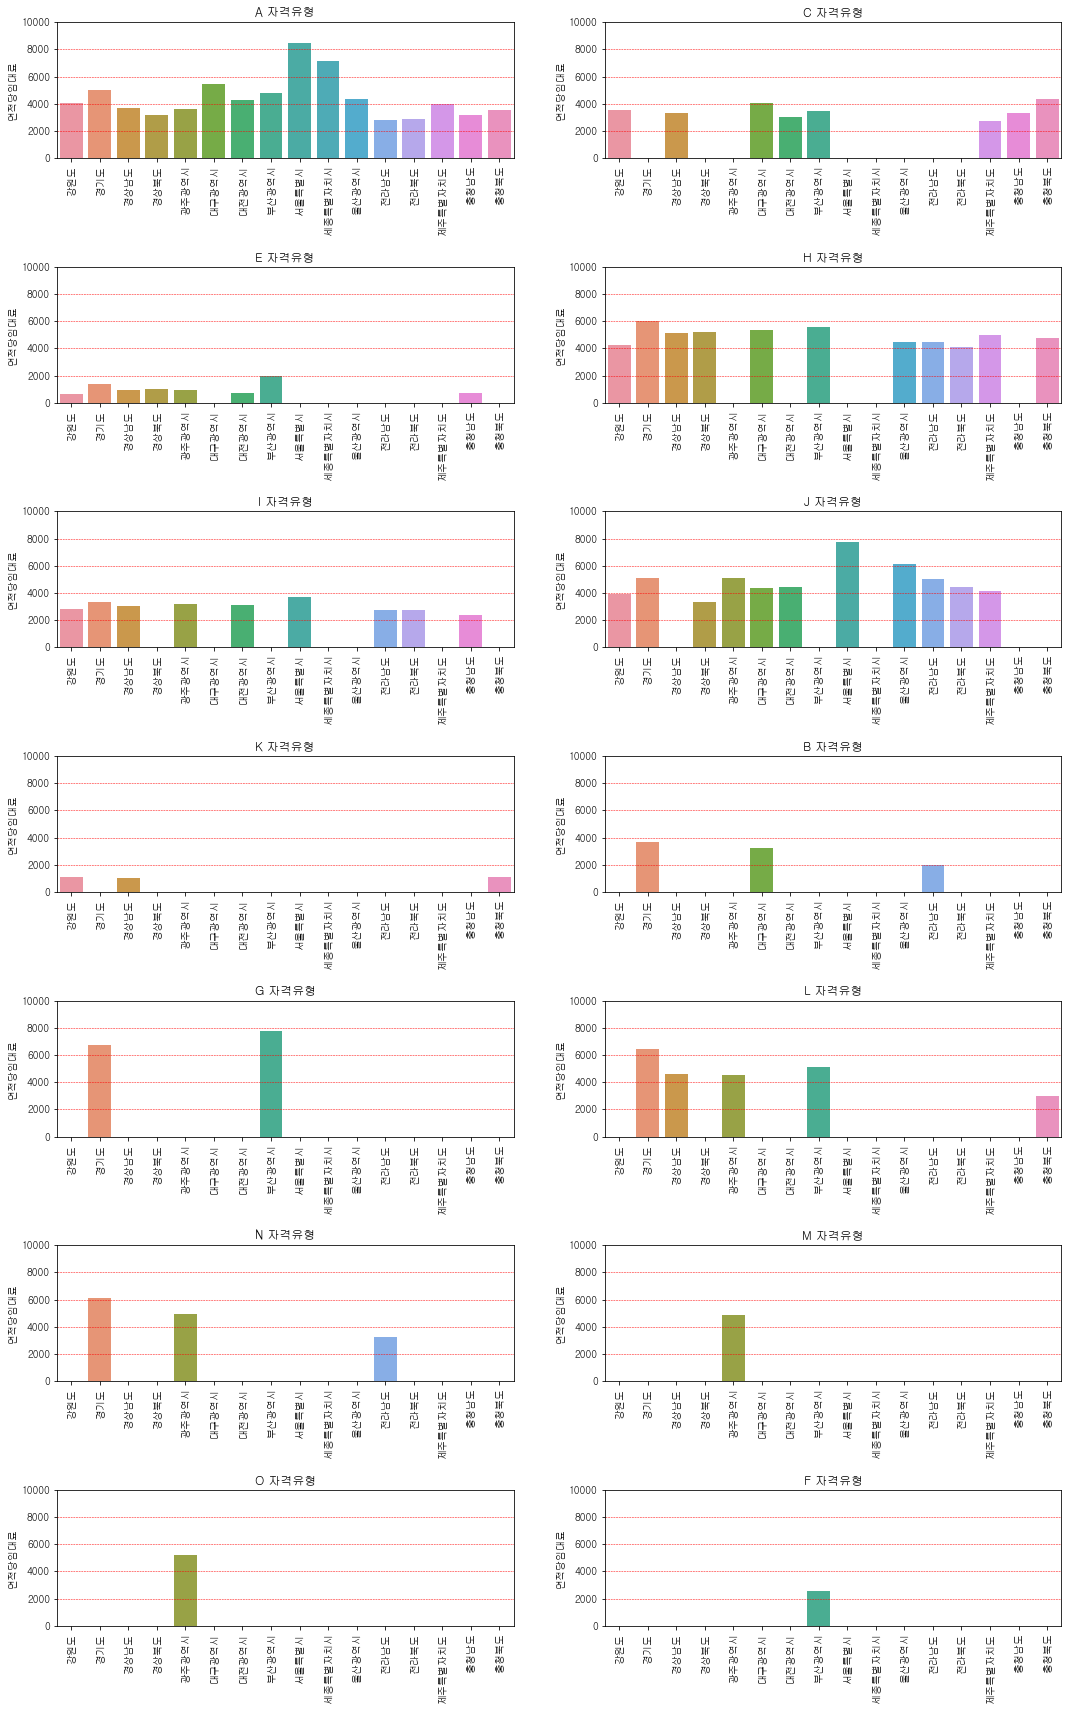

In [735]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 70))
for i, n in enumerate(list(mean_rent['자격유형'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.8)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['자격유형'] == n].sort_values('지역'),
                        x='지역', y='면적당임대료')
    plt.ylim(top = 10000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 8000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.title('{} 자격유형'.format(n))

- E, K 는 도대체 무엇이길래 모든 지역에서 낮게 형성되는가?
- I도 상대적으로 낮다. 왜 그럴까?

- 확실히 보면, 자격유형이 임대료에 상당히 많은 영향을 미치며, 공급유형이 대체로 자격유형과 연관이 있습니다.
- 동일 단지라고 해서 임대료가 비슷하지가 않습니다.
- 차라리 해당 자격유형의 임대료를 평균으로 산정하고, 국민임대일반지수를 곱해주는 것이 더 나을 수도 있을 것 같습니다.

### 단지내 총 환산보증금액

In [736]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [737]:
train_depot = pd.merge(train_danji, train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index(),
                       how='inner', on='단지코드')

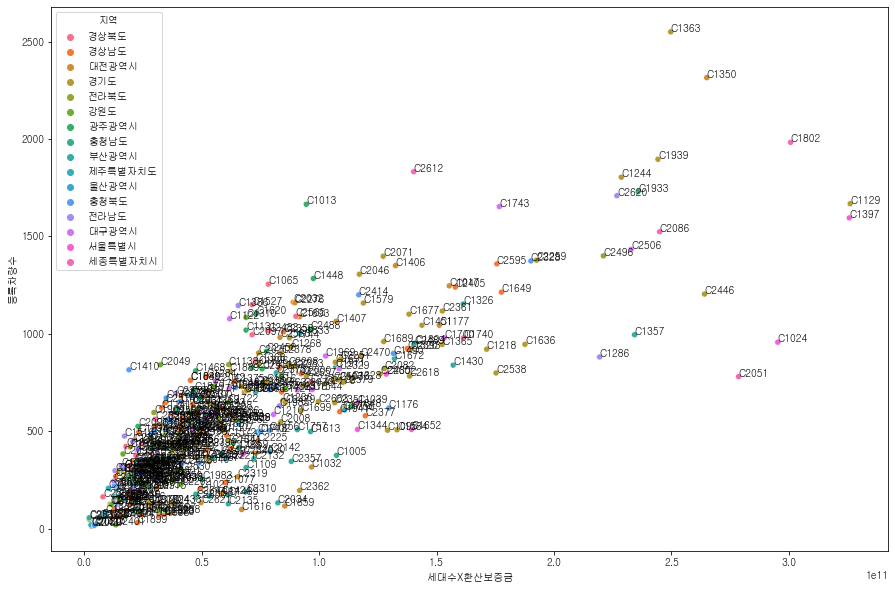

In [738]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_depot, x='세대수X환산보증금', y='등록차량수', hue='지역')
for i, code in enumerate(train_depot['단지코드']):
    plots.annotate(code, (train_depot['세대수X환산보증금'][i], train_depot['등록차량수'][i]))
plt.show()

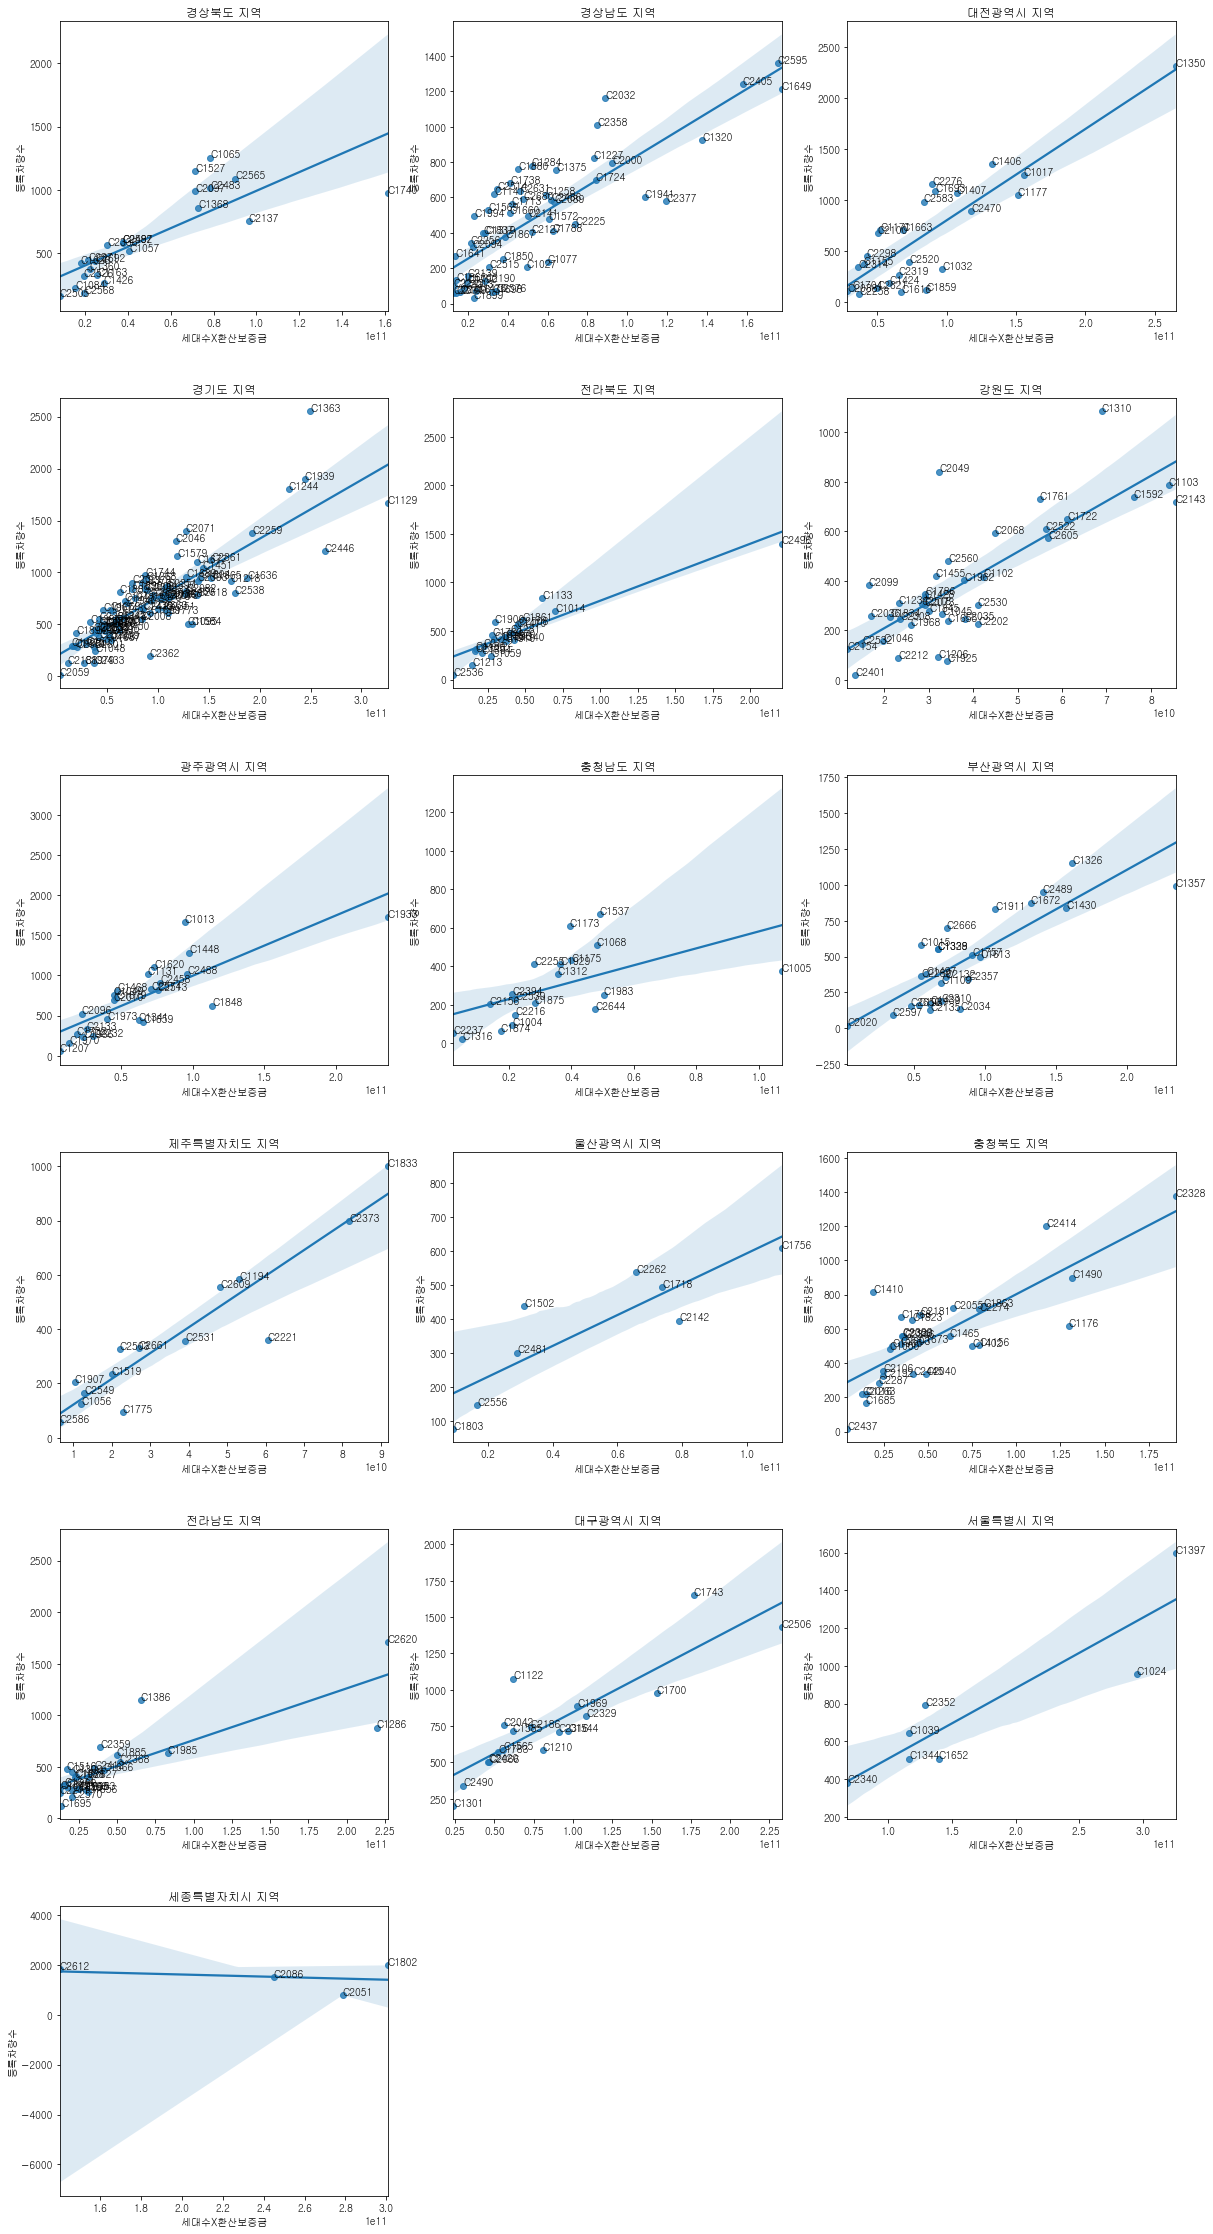

In [739]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_depot['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_depot.loc[train_depot['지역'] == n], x='세대수X환산보증금', y='등록차량수')
    for i, code in enumerate(train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['세대수X환산보증금'][i],
                              train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

- 확실히 총세대수, 주차면수, 건축연면적보다는 휘귀선이 조금 더 정확한 것을 알 수 있습니다.

### 대중교통 인프라

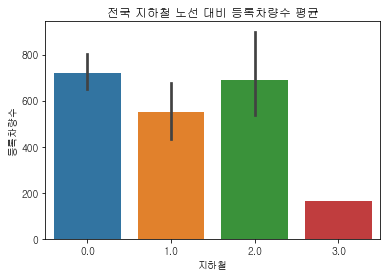

In [740]:
sns.barplot(data=train_danji.loc[train_danji['지역'].isin(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시'])],
            x='지하철', y='등록차량수')
plt.title('전국 지하철 노선 대비 등록차량수 평균')
plt.show()

별다른 정보를 주지 못하고 있다.

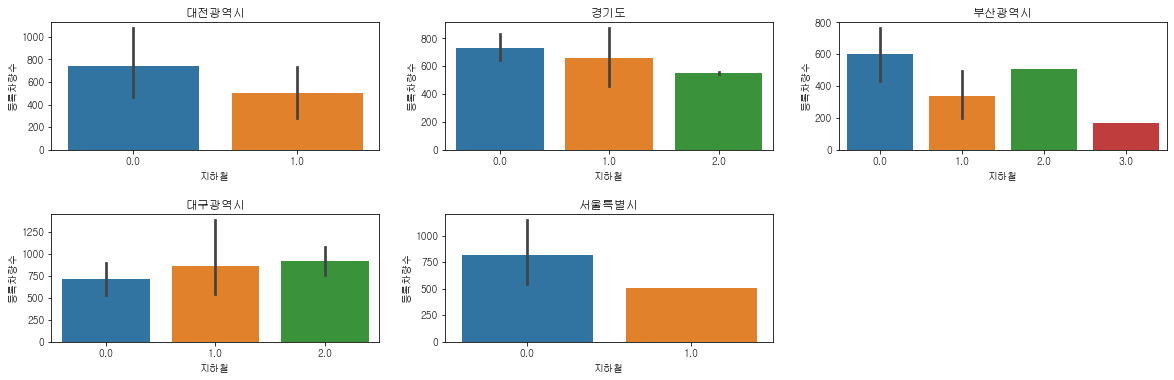

In [741]:
fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시']):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.barplot(data=train_danji.loc[train_danji['지역'] == n], x='지하철', y='등록차량수')
    plt.title(n)

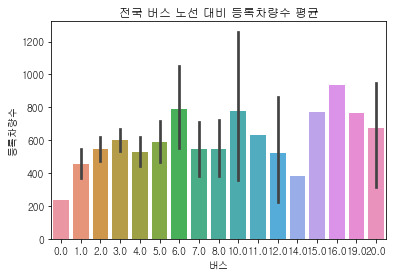

In [742]:
sns.barplot(data=train_danji, x='버스', y='등록차량수')
plt.title('전국 버스 노선 대비 등록차량수 평균')
plt.show()

오히려 버스 정류장이 많을수록 등록차량수가 늘어나는 패턴을 보인다.

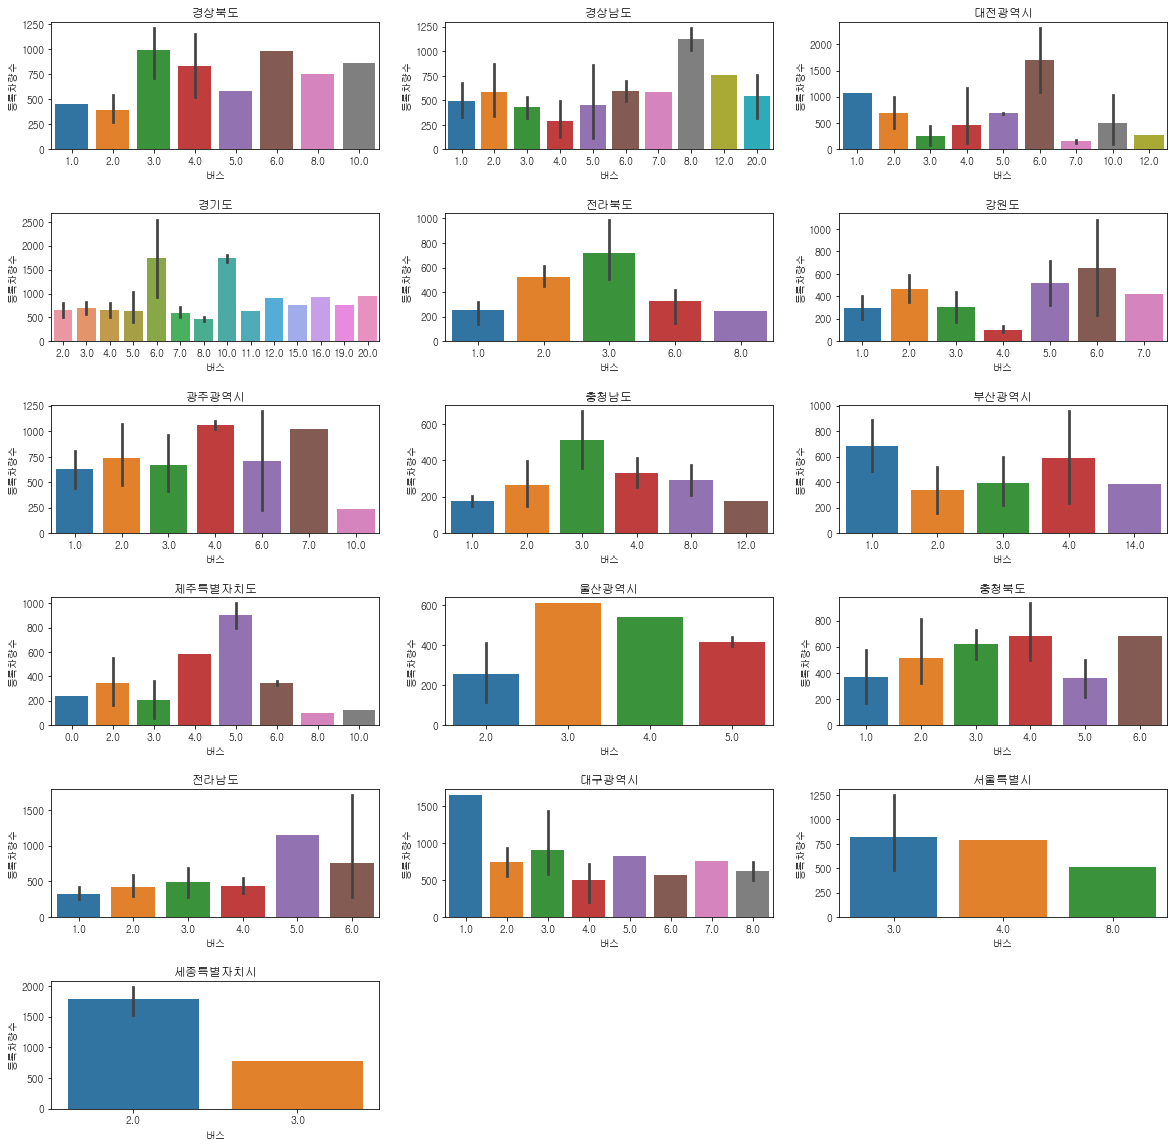

In [743]:
fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.barplot(data=train_danji.loc[train_danji['지역'] == n], x='버스', y='등록차량수')
    plt.title(n)

지하철 하나가 버스 3개 수준이라면?

In [744]:
train_danji['대중교통'] = (train_danji['지하철'] * 3) + train_danji['버스']

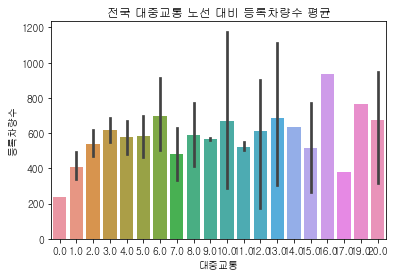

In [745]:
sns.barplot(data=train_danji, x='대중교통', y='등록차량수')
plt.title('전국 대중교통 노선 대비 등록차량수 평균')
plt.show()

# TESTING

### 1. 방의 개수가 차량 보유에 영향을 미치는가?

In [991]:
train.loc[train['전용면적'] < 35, '방개수'] = '1룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '2룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '3룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '4룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '5룸'

In [992]:
test.loc[test['전용면적'] < 35, '방개수'] = '1룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '2룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '3룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '4룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '5룸'

In [891]:
rooms = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='방개수', values='전용면적별세대수',
                       aggfunc='sum')

In [892]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [750]:
rooms_danji = pd.concat([rooms, temp], axis=1)

In [751]:
rooms_danji['1룸비율'] = rooms_danji['1룸'] / rooms_danji['총세대수']
rooms_danji['2룸비율'] = rooms_danji['2룸'] / rooms_danji['총세대수']
rooms_danji['3룸비율'] = rooms_danji['3룸'] / rooms_danji['총세대수']
rooms_danji['4룸비율'] = rooms_danji['4룸'] / rooms_danji['총세대수']
rooms_danji['5룸비율'] = rooms_danji['5룸'] / rooms_danji['총세대수']

rooms_danji['단지내주차면수/총세대수'] = rooms_danji['단지내주차면수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/총세대수'] = rooms_danji['등록차량수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/단지내주차면수'] = rooms_danji['등록차량수'] / rooms_danji['단지내주차면수']

In [752]:
rooms_cols = ['1룸비율', '2룸비율', '3룸비율', '4룸비율', '5룸비율']

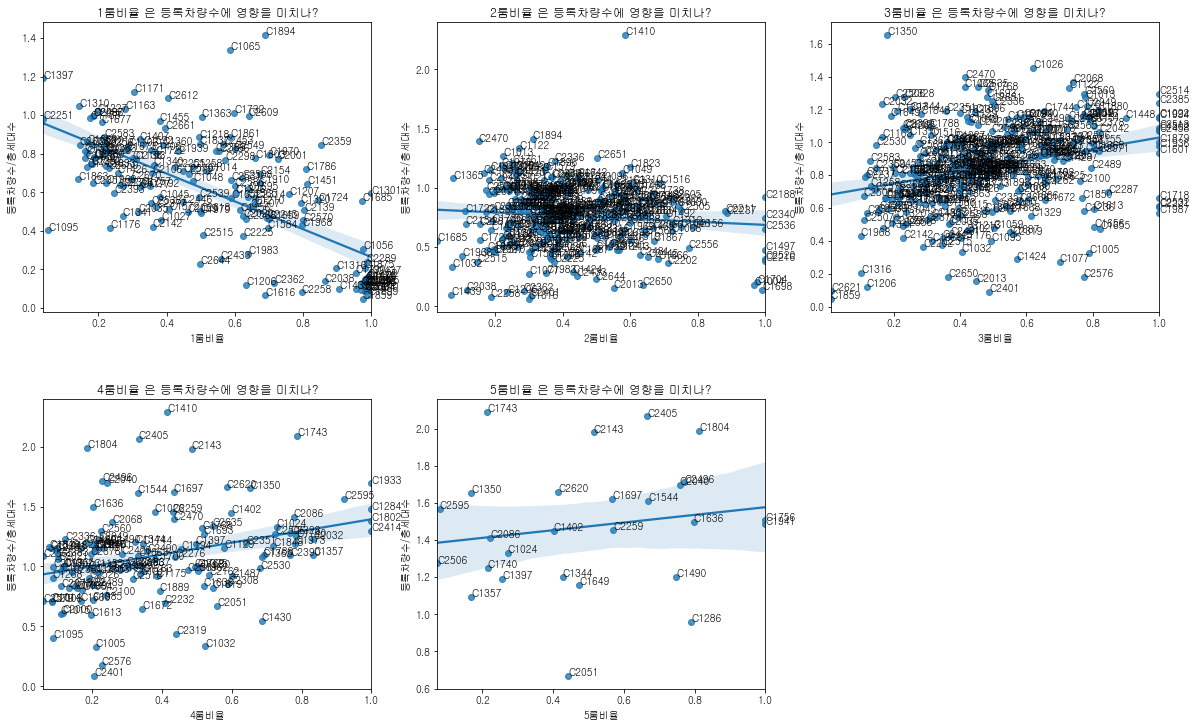

In [753]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

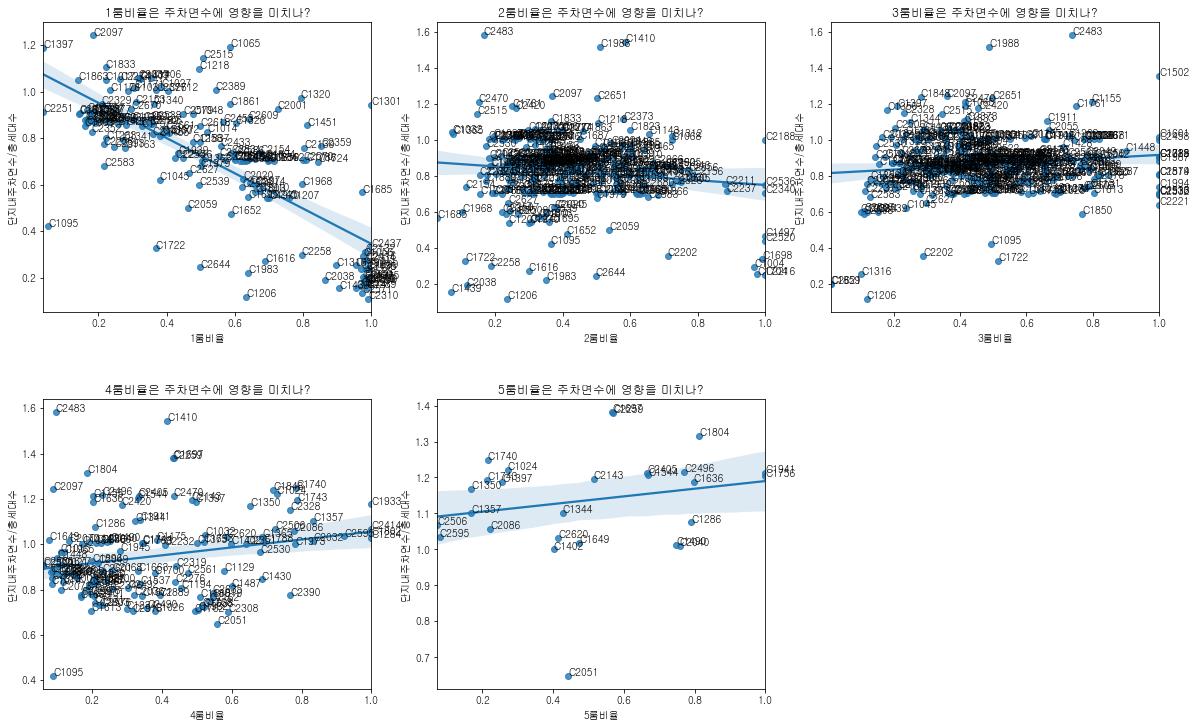

In [754]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 2. 크기 분류가 차량 보유에 영향을 미치는가?

In [993]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

In [756]:
size = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='전용면적구분', values='전용면적별세대수',
                       aggfunc='sum')

In [757]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [758]:
size_danji = pd.concat([size, temp], axis=1)

In [759]:
size_danji['소형비율'] = size_danji['소형'] / size_danji['총세대수']
size_danji['중형비율'] = size_danji['중형'] / size_danji['총세대수']
size_danji['대형비율'] = size_danji['대형'] / size_danji['총세대수']

size_danji['단지내주차면수/총세대수'] = size_danji['단지내주차면수'] / size_danji['총세대수']
size_danji['등록차량수/총세대수'] = size_danji['등록차량수'] / size_danji['총세대수']
size_danji['등록차량수/단지내주차면수'] = size_danji['등록차량수'] / size_danji['단지내주차면수']

In [760]:
size_cols = ['소형비율', '중형비율', '대형비율']

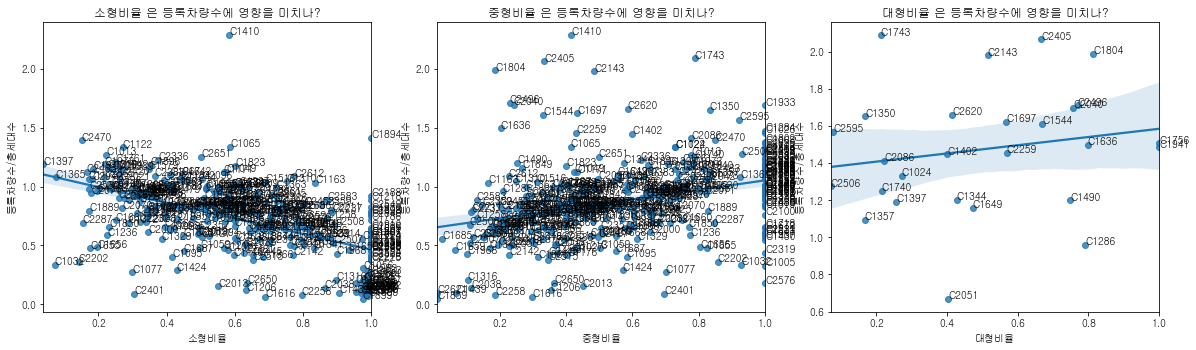

In [761]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

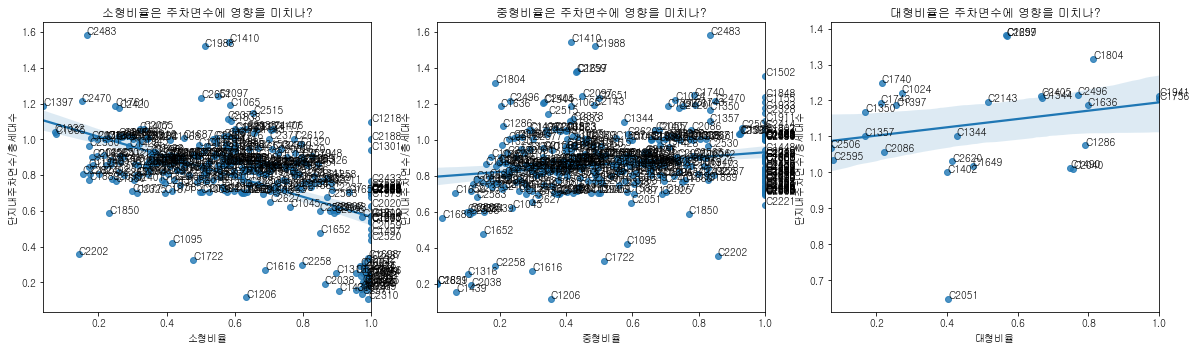

In [762]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 3. 땅값이 중요할까?

단지코드별 평균 면적당환산보증금이 그나마 지가에 가깝지 않을까 합니다

In [763]:
train_land = pd.merge(train_danji, train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index(),
                      how='inner', on='단지코드')

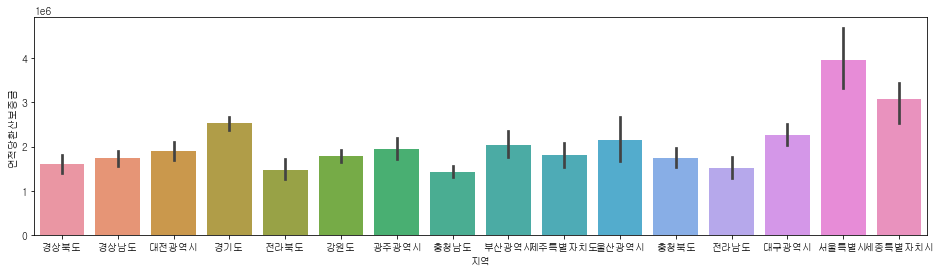

In [764]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train_land, x='지역', y='면적당환산보증금')
plt.show()

In [765]:
train_land['세대당등록차량수'] = train_land['등록차량수'] / train_land['총세대수']

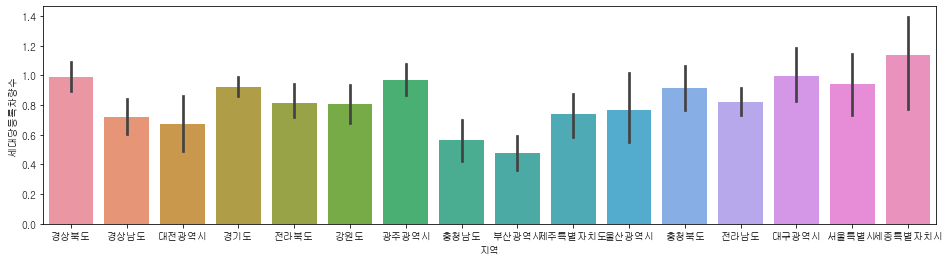

In [766]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train_land, x='지역', y='세대당등록차량수')
plt.show()

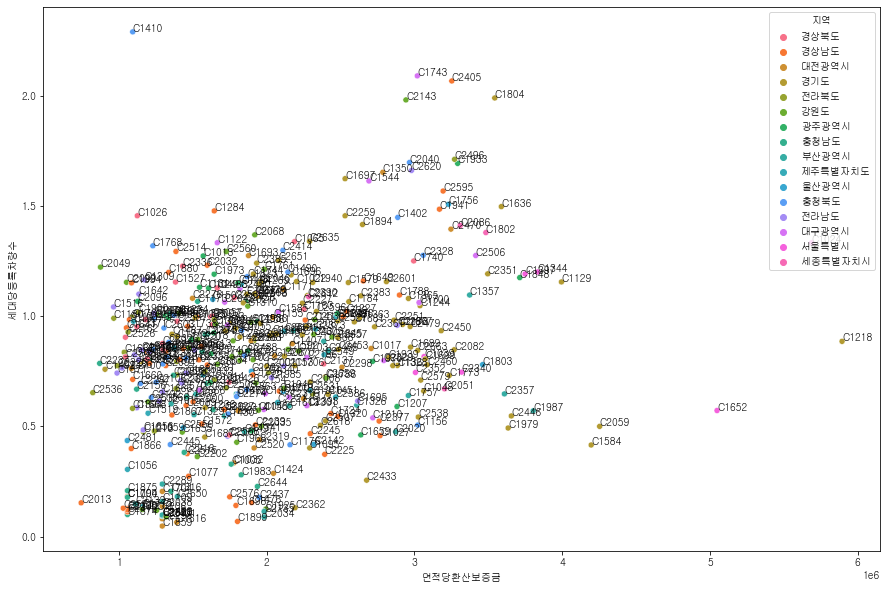

In [767]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_land, x='면적당환산보증금', y='세대당등록차량수', hue='지역')
for i, code in enumerate(train_land['단지코드']):
    plots.annotate(code, (train_land['면적당환산보증금'][i], train_land['세대당등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

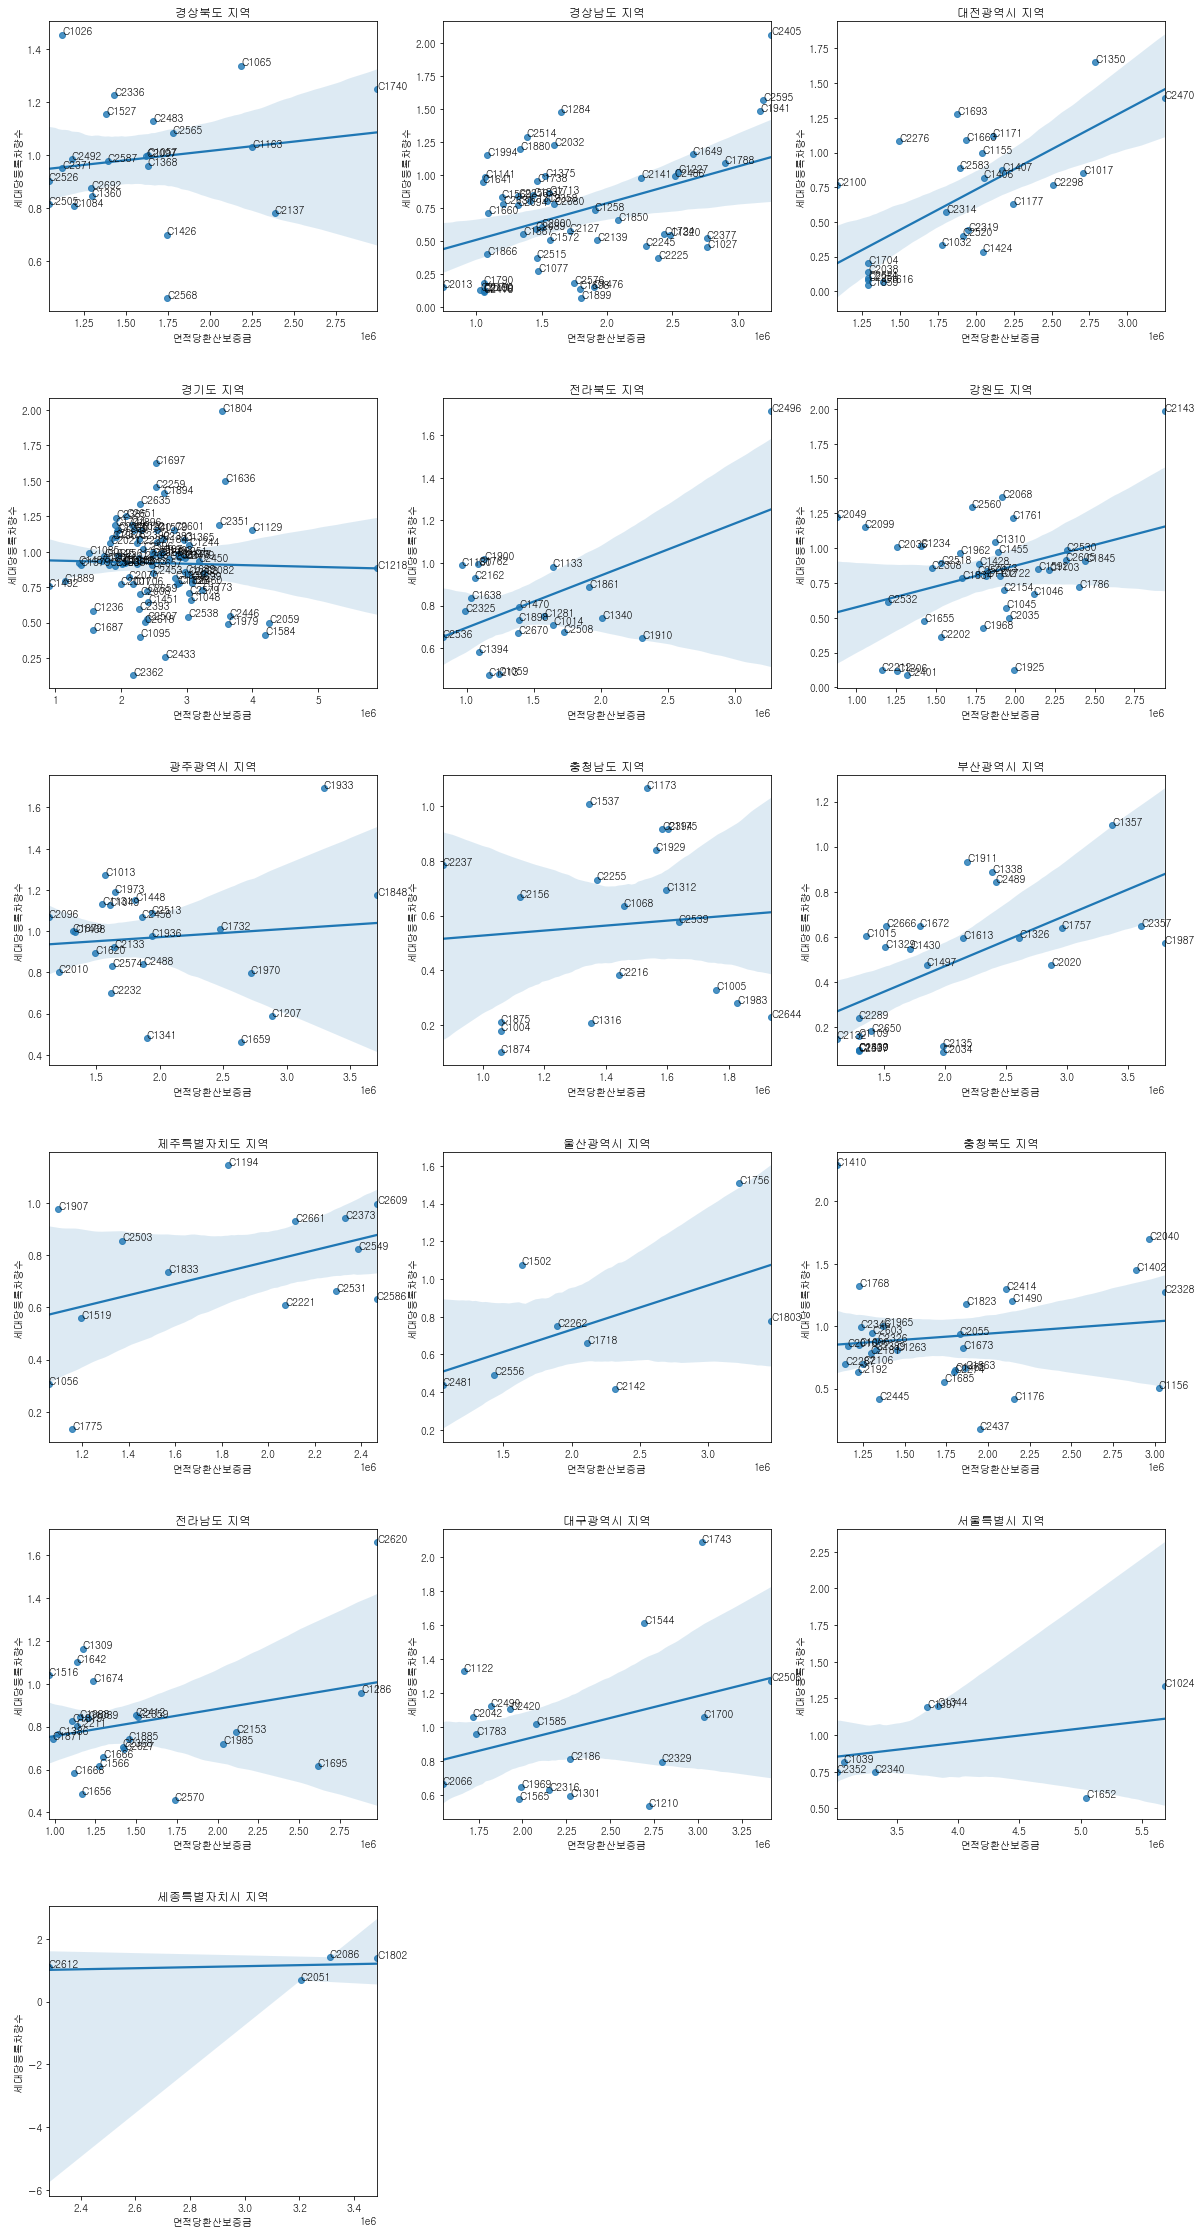

In [768]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_land['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_land.loc[train_land['지역'] == n], x='면적당환산보증금', y='세대당등록차량수')
    for i, code in enumerate(train_land.loc[train_land['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_land.loc[train_land['지역'] == n].reset_index(drop=True)['면적당환산보증금'][i],
                              train_land.loc[train_land['지역'] == n].reset_index(drop=True)['세대당등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 4. 임대기간 X 임대료

In [769]:
train['공급유형'].unique()

array(['국민임대', '공공임대(50년)', '영구임대', '공공임대(10년)', '공공임대(분납)', '장기전세',
       '행복주택'], dtype=object)

- 국민임대: 최장 30년
- 공공임대: 임대 후 분양, 50년, 10년, 5년
- 공공분납: 임대 후 분양, 10년, 입주 시 보증금을 많이 내고 임대료가 낮음
- 영구임대: 국민임대의 장기 버전, 50년
- 장기전세: 전세로 장기 거주
- 행복주택: 30년, 청년은 6년


- 연도가 정해져 있지 않으면 10년으로 산정하면 얼추 맞다.

In [774]:
train.loc[~train['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    train.loc[~train['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + train.loc[~train['공급유형'].isin(['공공임대(5년)']), '임대료'] * 120
)

In [775]:
train.loc[train['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    train.loc[train['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + train.loc[train['공급유형'].isin(['공공임대(5년)']), '임대료'] * 60
)

In [780]:
test.loc[~test['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    test.loc[~test['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + test.loc[~test['공급유형'].isin(['공공임대(5년)']), '임대료'] * 120
)

In [781]:
test.loc[test['공급유형'].isin(['공공임대(5년)']), '만기임대료'] = (
    test.loc[test['공급유형'].isin(['공공임대(5년)']), '임대보증금']
    + test.loc[test['공급유형'].isin(['공공임대(5년)']), '임대료'] * 60
)

In [788]:
train['만기임대료X세대수'] = train['만기임대료'] * train['전용면적별세대수']
test['만기임대료X세대수'] = test['만기임대료'] * test['전용면적별세대수']

In [789]:
train_land = pd.merge(train_danji, train.groupby(['단지코드'])['만기임대료X세대수'].sum().reset_index(),
                      how='inner', on='단지코드')

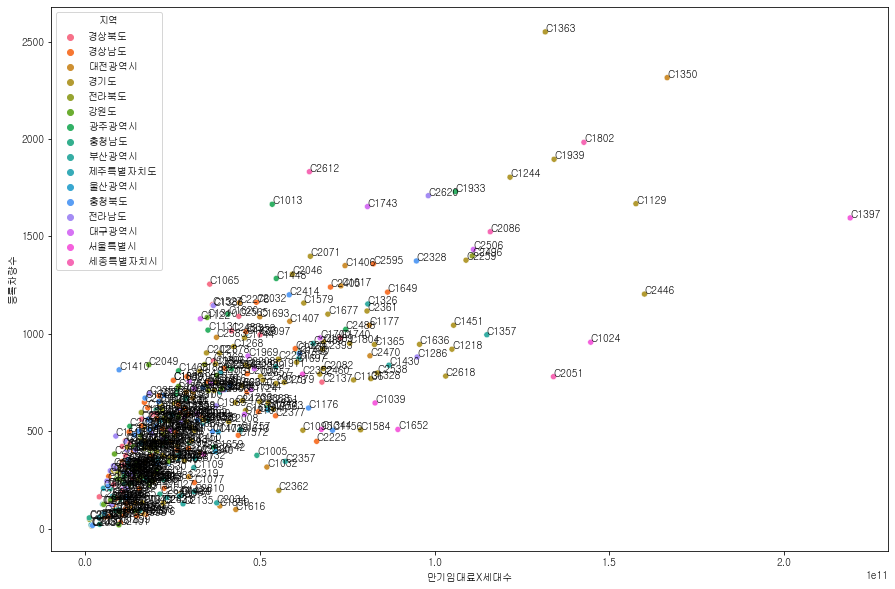

In [790]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_land, x='만기임대료X세대수', y='등록차량수', hue='지역')
for i, code in enumerate(train_land['단지코드']):
    plots.annotate(code, (train_land['만기임대료X세대수'][i], train_land['등록차량수'][i]))
#plt.xlim(right=4000)
plt.show()

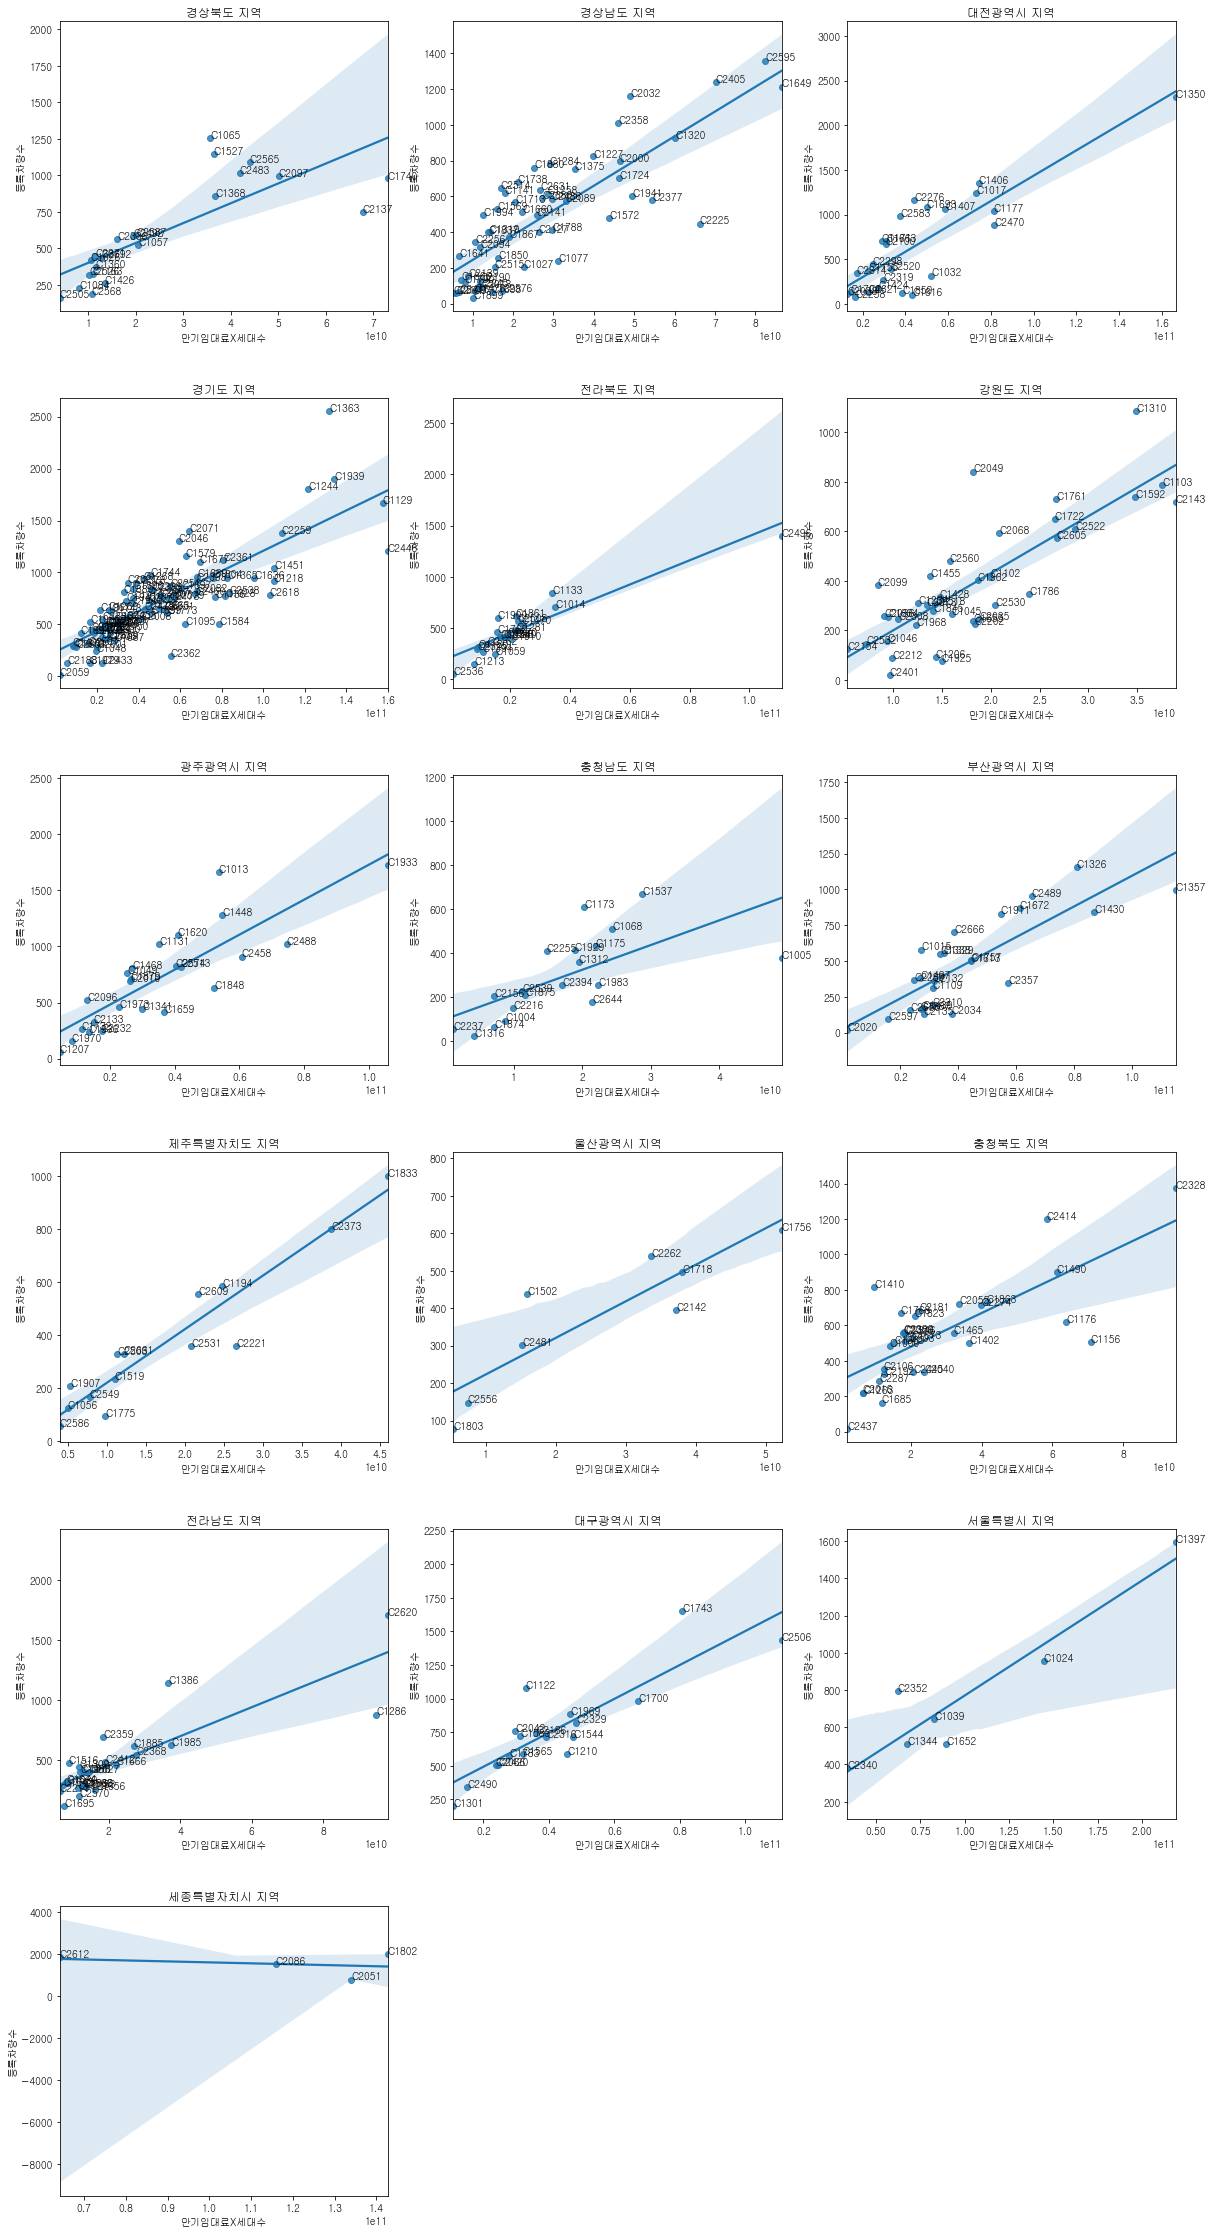

In [791]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_land['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_land.loc[train_land['지역'] == n], x='만기임대료X세대수', y='등록차량수')
    for i, code in enumerate(train_land.loc[train_land['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_land.loc[train_land['지역'] == n].reset_index(drop=True)['만기임대료X세대수'][i],
                              train_land.loc[train_land['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

### 4. 지역별 세대, 성별 분포는 어떤 영향을 미칠까?

In [429]:
ag = age_gender.set_index('지역')

In [430]:
# 성인(20대~60대)비중합
ag.loc[:, '청년비중'] = ag.loc[:, (ag.columns.str.contains('20대')) | (ag.columns.str.contains('30대')) | (ag.columns.str.contains('40대')) | (ag.columns.str.contains('50대')) | (ag.columns.str.contains('60대'))].sum(axis=1)
# 미성년자(10대이하)비중
ag.loc[:, '미성년자비중'] = ag.loc[:, (ag.columns.str.contains('10대'))].sum(axis=1)
# 노인비중(70대~)비중합
ag.loc[:, '노년비중'] = ag.loc[:, (ag.columns.str.contains('70대')) | (ag.columns.str.contains('80대')) | (ag.columns.str.contains('90대')) | (ag.columns.str.contains('100대'))].sum(axis=1)
# 성인여성비중
ag.loc[:, '청년여성비중'] = ag.loc[:, ['20대(여자)', '30대(여자)', '40대(여자)', '50대(여자)', '60대(여자)']].sum(axis=1)
# 성인남성비중
ag.loc[:, '청년남성비중'] = ag.loc[:, ['20대(남자)', '30대(남자)', '40대(남자)', '50대(남자)', '60대(남자)']].sum(axis=1)

# Modeling

In [906]:
train.head()

단지코드 임대건물구분  지역   전용면적  전용면적별세대수   공가수       임대보증금       임대료  지하철   버스  \
0  C2483    아파트   3  39.72       134  38.0  15667000.0  103680.0  0.0  3.0   
1  C2483    아파트   3  39.72        15  38.0  15667000.0  103680.0  0.0  3.0   
2  C2483    아파트   3  51.93       385  38.0  27304000.0  184330.0  0.0  3.0   
3  C2483    아파트   3  51.93        15  38.0  27304000.0  184330.0  0.0  3.0   
4  C2483    아파트   3  51.93        41  38.0  27304000.0  184330.0  0.0  3.0   

   단지내주차면수   등록차량수  총세대수         면적당보증금       면적당임대료       환산보증금  공공임대   국민임대  \
0   1425.0  1015.0   900  394436.052367  2610.271903  52369720.0   0.0  900.0   
1   1425.0  1015.0   900  394436.052367  2610.271903  52369720.0   0.0  900.0   
2   1425.0  1015.0   900  525784.710187  3549.585981  92556820.0   0.0  900.0   
3   1425.0  1015.0   900  525784.710187  3549.585981  92556820.0   0.0  900.0   
4   1425.0  1015.0   900  525784.710187  3549.585981  92556820.0   0.0  900.0   

   영구임대  장기전세  행복주택      A    B    C    E    F    G    H    I    J    K    L  \
0   0.0   0.0   0.0  900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0   0.0   0.0  900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0   0.0   0.0  900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0   0.0   0.0  900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0   0.0   0.0  900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     M    N    O     세대수X환산보증금      면적당환산보증금   1룸     2룸     3룸    4룸   5룸  \
0  0.0  0.0  0.0  7.848731e+10  1.665119e+06  0.0  149.0  665.0  86.0  0.0   
1  0.0  0.0  0.0  7.848731e+10  1.665119e+06  0.0  149.0  665.0  86.0  0.0   
2  0.0  0.0  0.0  7.848731e+10  1.665119e+06  0.0  149.0  665.0  86.0  0.0   
3  0.0  0.0  0.0  7.848731e+10  1.665119e+06  0.0  149.0  665.0  86.0  0.0   
4  0.0  0.0  0.0  7.848731e+10  1.665119e+06  0.0  149.0  665.0  86.0  0.0   

    대형     소형     중형     건축연면적  
0  0.0  149.0  751.0  45605.89  
1  0.0  149.0  751.0  45605.89  
2  0.0  149.0  751.0  45605.89  
3  0.0  149.0  751.0  45605.89  
4  0.0  149.0  751.0  45605.89

In [994]:
# 공급유형 unstack
temp = train.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['공급유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['공급유형'])], temp, on='단지코드')

In [995]:
# 자격유형 unstack
temp = train.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['자격유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['자격유형'])], temp, on='단지코드')

In [996]:
# 면적당환산보증금세대수 합계로 산출
temp = train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')

In [997]:
# 단지평균면적당환산보증금 산출
temp = train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['면적당환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['면적당환산보증금'])], temp, on='단지코드')

In [998]:
# # 만기임대료세대수 합계로 산출
# temp = train.groupby(['단지코드'])['만기임대료X세대수'].sum().reset_index()
# train = pd.merge(train.loc[:, ~train.columns.isin(['만기임대료X세대수'])], temp, on='단지코드')
# temp = test.groupby(['단지코드'])['만기임대료X세대수'].sum().reset_index()
# test = pd.merge(test.loc[:, ~test.columns.isin(['만기임대료X세대수'])], temp, on='단지코드')

In [999]:
# 방개수 unstack
temp = train.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['방개수'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['방개수'])], temp, on='단지코드')

In [1000]:
# 전용면적구분 unstack
temp = train.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['전용면적구분'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['전용면적구분'])], temp, on='단지코드')

In [1001]:
# 건축연면적 합계로 산출
temp = train.groupby(['단지코드'])['건축연면적'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['건축연면적'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['건축연면적'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['건축연면적'])], temp, on='단지코드')

In [1002]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

In [1003]:
# 전처리가 끝나서 필요없는 변수 삭제
train.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
            '임대료', '환산보증금', '면적당보증금', '면적당임대료'], axis=1, inplace=True)
test.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
           '임대료', '환산보증금', '면적당보증금', '면적당임대료'], axis=1, inplace=True)

In [1004]:
# 단지고유의 레코드만 남겨줍니다.
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [1005]:
train.shape, test.shape

((420, 40), (147, 35))

In [1006]:
set(train.columns).difference(test.columns)

{'B', 'F', 'O', '등록차량수', '장기전세'}

In [1007]:
train.drop(['B', 'F', 'O', '장기전세'], axis=1, inplace=True)

In [1008]:
# test['B'] = 0
# test['F'] = 0
# test['O'] = 0
# test['공공분양'] = 0
# test['공공임대(5년)'] = 0
# test['장기전세'] = 0

In [1009]:
train.shape, test.shape

((420, 36), (147, 35))

In [447]:
# ag = ag.reset_index()
# ag['지역'] = ag['지역'].map(region_dict)

In [1017]:
train_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1)

상가세대수    상가면적합
단지코드                 
C1004     17   664.61
C1056     10   318.40
C1109     20   941.32
C1206     10   455.89
C1439     45  1934.04
C1476      6   232.66
C1616     19  1427.43
C1698      4   128.40
C1704     15   572.41
C1722      6   232.66
C1775     15   583.25
C1790     30  1093.93
C1859     35  1999.44
C1874     27   842.82
C1875     19   706.70
C1899      4   128.40
C1925      4   168.46
C1983     10   445.05
C2034     26   988.96
C2038     17   664.61
C2109     15   572.41
C2132     43  2397.37
C2135     17   659.90
C2190     17   449.89
C2212     11   583.25
C2258     17   664.61
C2289     20  1427.03
C2310     20  1427.03
C2416      8   580.97
C2571     13   508.73
C2597     29  1093.93
C2621     10   455.89
C2644      3   148.34

In [1019]:
test_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index()

단지코드  상가세대수    상가면적합
0  C1006     20  1428.23
1  C1729     17   663.40
2  C1812     25  1091.81
3  C2033     22   963.87
4  C2177     22   963.87
5  C2253     28  1101.96
6  C2676     43  2394.05

In [1020]:
train = pd.merge(train, train_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index(),
                 how='left', on='단지코드')
test = pd.merge(test, test_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index(),
                how='left', on='단지코드')

In [1030]:
train.fillna(0).tail(50)

단지코드  지역   공가수  지하철   버스  단지내주차면수   등록차량수  총세대수  공공임대(10년)  공공임대(50년)  \
370  C2351   1   6.0  0.0  4.0    542.0   646.0   542      542.0        0.0   
371  C2506   4  14.0  0.0  3.0   1201.0  1433.0  1124     1124.0        0.0   
372  C1697   1   4.0  0.0  3.0    727.0   854.0   526      526.0        0.0   
373  C2259   1   5.0  0.0  2.0   1306.0  1378.0   947      947.0        0.0   
374  C1786   9  25.0  0.0  3.0    338.0   345.0   480        0.0        0.0   
375  C1357  15  27.0  0.0  1.0   1001.0   995.0   908      908.0        0.0   
376  C2570   7  14.0  0.0  2.0    318.0   205.0   450        0.0        0.0   
377  C1652   0  20.0  1.0  8.0    423.0   509.0   890        0.0        0.0   
378  C1565   4  42.0  0.0  3.0    719.0   588.0  1020        0.0        0.0   
379  C1910   8  21.0  0.0  2.0    350.0   396.0   612        0.0        0.0   
380  C2359   7   9.0  0.0  3.0    629.0   693.0   820        0.0        0.0   
381  C2139  10  11.0  0.0  4.0    232.0   155.0   306        0.0        0.0   
382  C1979   1  17.0  0.0  4.0    183.0   133.0   270        0.0        0.0   
383  C1803  11  13.0  0.0  2.0     57.0    78.0   100        0.0        0.0   
384  C2508   8  13.0  0.0  3.0    496.0   568.0   842        0.0        0.0   
385  C2531  12  22.0  0.0  6.0    397.0   358.0   540        0.0        0.0   
386  C1695   7  12.0  0.0  4.0    109.0   123.0   200        0.0        0.0   
387  C2556  11  21.0  0.0  2.0    249.0   148.0   300        0.0        0.0   
388  C2086   2   7.0  0.0  2.0   1142.0  1524.0  1080     1080.0        0.0   
389  C1544   4  10.0  0.0  2.0    533.0   713.0   442      442.0        0.0   
390  C2154   9   2.0  0.0  1.0    131.0   124.0   178        0.0        0.0   
391  C2496   8   0.0  0.0  3.0    995.0  1400.0   818      818.0        0.0   
392  C1756  11   1.0  0.0  3.0    486.0   609.0   404      404.0        0.0   
393  C2362   1  46.0  0.0  2.0   1055.0   196.0  1500        0.0        0.0   
394  C2568   3  31.0  0.0  2.0    287.0   189.0   410        0.0        0.0   
395  C2245  10  22.0  0.0  1.0    114.0    98.0   210        0.0        0.0   
396  C2059   1   1.0  1.0  3.0     13.0    13.0    26        0.0        0.0   
397  C2549  12  17.0  0.0  2.0    141.0   165.0   200        0.0        0.0   
398  C1584   1  40.0  0.0  3.0    857.0   507.0  1220        0.0        0.0   
399  C2298  13  21.0  0.0  3.0    408.0   444.0   578        0.0        0.0   
400  C2225  10  49.0  0.0  3.0    842.0   448.0  1200        0.0        0.0   
401  C1218   1  28.0  0.0  6.0   1140.0   921.0  1040        0.0        0.0   
402  C2328   6   4.0  0.0  2.0   1239.0  1374.0  1077     1077.0        0.0   
403  C1045   9  13.0  0.0  2.0    288.0   266.0   464        0.0        0.0   
404  C1207   5  10.0  0.0  6.0     54.0    59.0   100        0.0        0.0   
405  C1970   5  16.0  0.0  6.0    108.0   159.0   200        0.0        0.0   
406  C1732   5  17.0  0.0  3.0    188.0   267.0   264        0.0        0.0   
407  C2433   1  19.0  0.0  2.0    389.0   130.0   508        0.0        0.0   
408  C1894   1  13.0  0.0  4.0    212.0   419.0   296        0.0        0.0   
409  C1156   6  47.0  0.0  3.0    700.0   505.0   998        0.0        0.0   
410  C2142  11  41.0  0.0  5.0    772.0   396.0   946        0.0        0.0   
411  C2153   7  20.0  0.0  3.0    345.0   280.0   362        0.0        0.0   
412  C2186   4   0.0  0.0  8.0    664.0   744.0   916        0.0        0.0   
413  C1176   6  55.0  0.0  3.0   1493.0   619.0  1486        0.0        0.0   
414  C2446   1  32.0  0.0  5.0   1570.0  1204.0  2200        0.0        0.0   
415  C2586  12   7.0  0.0  3.0     66.0    57.0    90        0.0        0.0   
416  C2035   9  24.0  0.0  1.0    521.0   246.0   492        0.0        0.0   
417  C2020  15   7.0  1.0  2.0     25.0    19.0    40        0.0        0.0   
418  C2437   6  12.0  0.0  1.0     30.0    16.0    90        0.0        0.0   
419  C2532   9   7.0  0.0  1.0    166.0   146.0   239   

In [1021]:
train.shape, test.shape

((420, 38), (147, 37))

In [915]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]
x_code = test['단지코드']

In [916]:
x_train.shape, y_train.shape, x_test.shape, x_code.shape

((420, 32), (420,), (147, 32), (147,))

In [917]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [918]:
rf.oob_score_

0.7801704583032157

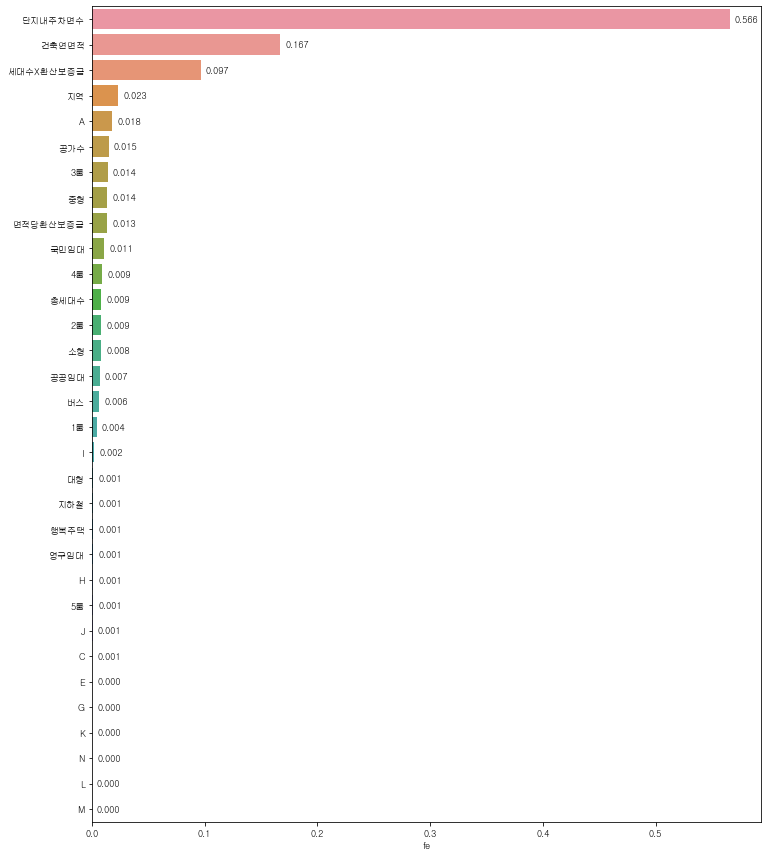

In [919]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [920]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [921]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [922]:
sub.head()

code       num
0  C1072   798.625
1  C1128  1187.565
2  C1456   518.485
3  C1840   539.565
4  C1332  1242.225

In [923]:
sub.to_csv('submission/parking_210714_allnew3_공공임대합병.csv', index=False)

## FEATURE SELECTION

In [1010]:
# RFE는 Recursive Feature Elimination이라고 하여, 반복하여 변수를 제거해나가는 방식입니다.
from sklearn.feature_selection import RFE

In [1011]:
model = RandomForestRegressor(random_state=42)
rfe = RFE(model,
          5) # feature의 개수를 지정할 수 있습니다. 3개로 해봅니다.
rfe_fit = rfe.fit(x_train, y_train)

In [1012]:
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 5
Selected Features: [ True False False False  True False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False  True  True]
Feature Ranking: [ 1  3 16 11  1  5 12  9 14 18  2 21 23 26 17 22 19 25 27 28 24  1  6 13
 10  4  8 15 20  7  1  1]


In [1013]:
# rank를 확인할 수도 있습니다.
rfe_select = pd.DataFrame(rfe_fit.support_.tolist(), index=x_train.columns, columns=['true'])
rfe_select['rank'] = rfe_fit.ranking_.tolist()
rfe_select.sort_values('rank')

true  rank
지역          True     1
세대수X환산보증금   True     1
중형          True     1
단지내주차면수     True     1
건축연면적       True     1
A          False     2
공가수        False     3
3룸         False     4
총세대수       False     5
면적당환산보증금   False     6
소형         False     7
4룸         False     8
국민임대       False     9
2룸         False    10
버스         False    11
공공임대       False    12
1룸         False    13
영구임대       False    14
5룸         False    15
지하철        False    16
H          False    17
행복주택       False    18
J          False    19
대형         False    20
C          False    21
I          False    22
E          False    23
N          False    24
K          False    25
G          False    26
L          False    27
M          False    28

### llar

In [1077]:
LassoLars?

Init signature:
LassoLars(
    alpha=1.0,
    *,
    fit_intercept=True,
    verbose=False,
    normalize=True,
    precompute='auto',
    max_iter=500,
    eps=2.220446049250313e-16,
    copy_X=True,
    fit_path=True,
    positive=False,
    jitter=None,
    random_state=None,
)
Docstring:     
Lasso model fit with Least Angle Regression a.k.a. Lars

It is a Linear Model trained with an L1 prior as regularizer.

The optimization objective for Lasso is::

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Read more in the :ref:`User Guide <least_angle_regression>`.

Parameters
----------
alpha : float, default=1.0
    Constant that multiplies the penalty term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by :class:`LinearRegression`. For numerical reasons, using
    ``alpha = 0`` with the LassoLars object is not advised and you
    should prefer the LinearRegression object.

fit_intercept : bool, default=True
    whether to calculate 

In [1084]:
LassoLarsCV?

Init signature:
LassoLarsCV(
    *,
    fit_intercept=True,
    verbose=False,
    max_iter=500,
    normalize=True,
    precompute='auto',
    cv=None,
    max_n_alphas=1000,
    n_jobs=None,
    eps=2.220446049250313e-16,
    copy_X=True,
    positive=False,
)
Docstring:     
Cross-validated Lasso, using the LARS algorithm.

See glossary entry for :term:`cross-validation estimator`.

The optimization objective for Lasso is::

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

Read more in the :ref:`User Guide <least_angle_regression>`.

Parameters
----------
fit_intercept : bool, default=True
    whether to calculate the intercept for this model. If set
    to false, no intercept will be used in calculations
    (i.e. data is expected to be centered).

verbose : bool or int, default=False
    Sets the verbosity amount

max_iter : int, default=500
    Maximum number of iterations to perform.

normalize : bool, default=True
    This parameter is ignored when ``fit_intercept`` is

In [1096]:
llar = LassoLarsCV(cv=5, max_iter=5000, max_n_alphas=10000, normalize=True, verbose=True)

In [1097]:
llar.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


LassoLarsCV(copy_X=True, cv=5, eps=2.220446049250313e-16, fit_intercept=True,
            max_iter=5000, max_n_alphas=10000, n_jobs=None, normalize=True,
            positive=False, precompute='auto', verbose=True)

In [1098]:
pred = llar.predict(x_test)

In [1099]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [1100]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [1101]:
sub.head()

code          num
0  C1072   781.443441
1  C1128  1284.516694
2  C1456   483.376983
3  C1840   492.110432
4  C1332  1208.877779

In [466]:
sub.to_csv('submission/parking_210713_allnew+ag-withllar.csv', index=False)

### CatB

In [1056]:
x_train.columns

Index(['지역', '공가수', '지하철', '버스', '단지내주차면수', '총세대수', '공공임대', '국민임대', '영구임대',
       '행복주택', 'A', 'C', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       '세대수X환산보증금', '면적당환산보증금', '1룸', '2룸', '3룸', '4룸', '5룸', '대형', '소형', '중형',
       '건축연면적'],
      dtype='object')

In [1057]:
cat_features = [0]

In [1059]:
FOLD = 10
preds = []
fe = []

cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in cross.split(x_train, y_train):
    folds.append((train_idx, valid_idx))

models={}
for fold in range(FOLD):
    train_idx, valid_idx = folds[fold]
    X_tra = x_train.iloc[train_idx, :]
    y_tra = y_train.iloc[train_idx]
    X_val = x_train.iloc[valid_idx, :]
    y_val = y_train.iloc[valid_idx]

    model=CatBoostRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
    model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
              cat_features = cat_features,
              early_stopping_rounds=30, verbose=100)
    models[fold]=model

for k in range(FOLD):
    preds.append(models[k].predict(x_test)) 
    fe.append(models[k].feature_importances_)

0:	learn: 384.5470799	test: 384.5470799	test1: 372.7436989	best: 372.7436989 (0)	total: 52.9ms	remaining: 8m 49s
100:	learn: 159.6583009	test: 160.4079139	test1: 194.1719224	best: 194.1719224 (100)	total: 3.25s	remaining: 5m 18s
200:	learn: 126.7672715	test: 129.2806771	test1: 178.4167610	best: 178.4167610 (200)	total: 6.42s	remaining: 5m 13s
300:	learn: 110.1951247	test: 113.4447391	test1: 174.4295391	best: 174.4295391 (300)	total: 9.71s	remaining: 5m 13s
400:	learn: 92.1055333	test: 95.7246128	test1: 173.3853635	best: 173.3269733 (395)	total: 13s	remaining: 5m 11s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 173.0557281
bestIteration = 450

Shrink model to first 451 iterations.
0:	learn: 384.7195681	test: 384.7195681	test1: 375.1652317	best: 375.1652317 (0)	total: 55ms	remaining: 9m 10s
100:	learn: 167.0797803	test: 168.7642893	test1: 159.4826168	best: 159.4826168 (100)	total: 3.21s	remaining: 5m 15s
200:	learn: 130.7159136	test: 133.9609333	test1: 142.3879696	be

In [1060]:
pred = np.array(preds).mean(axis=0)

In [1061]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [1062]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [1063]:
sub.head()

code          num
0  C1072   770.027866
1  C1128  1280.605348
2  C1456   570.233506
3  C1840   477.837388
4  C1332  1195.773959

In [466]:
sub.to_csv('submission/parking_210713_allnew+ag-withllar.csv', index=False)

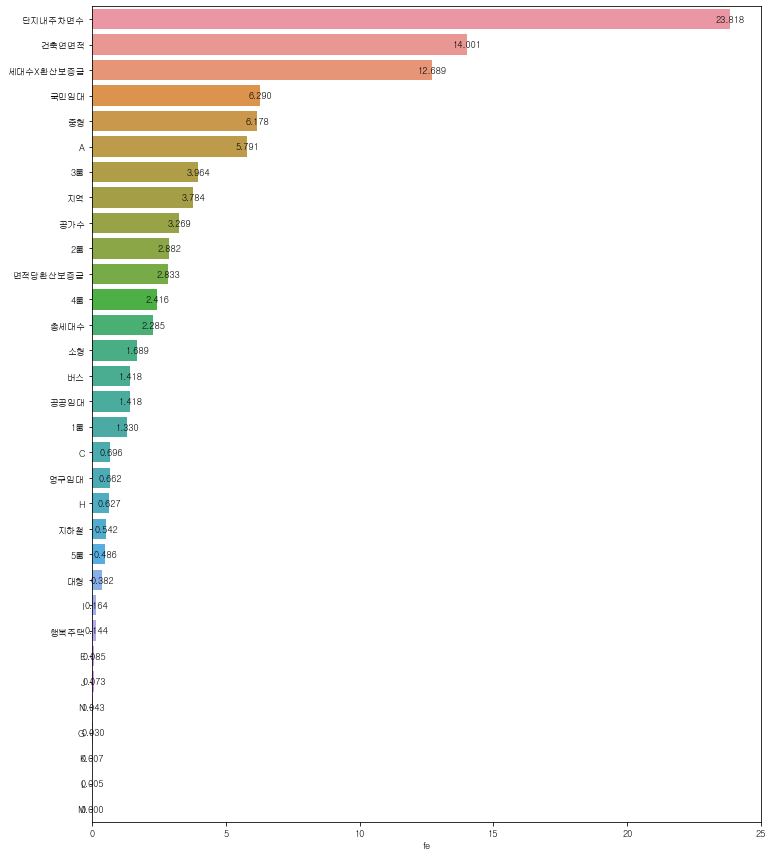

In [1064]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(np.array(fe).mean(axis=0),
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### LGBM

In [1071]:
FOLD = 10
preds = []
fe = []

cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in cross.split(x_train, y_train):
    folds.append((train_idx, valid_idx))

models={}
for fold in range(FOLD):
    train_idx, valid_idx = folds[fold]
    X_tra = x_train.iloc[train_idx, :]
    y_tra = y_train.iloc[train_idx]
    X_val = x_train.iloc[valid_idx, :]
    y_val = y_train.iloc[valid_idx]

    model=LGBMRegressor(learning_rate=0.0027, random_state=42, n_estimators=10000, cat_features = cat_features,)
    model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
              eval_metric='mae',
              early_stopping_rounds=30, verbose=100)
    models[fold]=model

for k in range(FOLD):
    preds.append(models[k].predict(x_test)) 
    fe.append(models[k].feature_importances_)

[LightGBM] [Warning] Unknown parameter: cat_features
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 240.314	training's l2: 104956	valid_1's l1: 207.044	valid_1's l2: 62350.8
[200]	training's l1: 197.523	training's l2: 73560.1	valid_1's l1: 178.928	valid_1's l2: 46562.7
[300]	training's l1: 165.606	training's l2: 54000.4	valid_1's l1: 156.641	valid_1's l2: 36776.4
[400]	training's l1: 142.523	training's l2: 41828.4	valid_1's l1: 139.792	valid_1's l2: 30919.7
[500]	training's l1: 125.188	training's l2: 33836.2	valid_1's l1: 130.097	valid_1's l2: 27866.1
[600]	training's l1: 111.971	training's l2: 28726.6	valid_1's l1: 121.576	valid_1's l2: 24712.1
[700]	training's l1: 102.504	training's l2: 25300.7	valid_1's l1: 115.748	valid_1's l2: 22989.4
[800]	training's l1: 95.4662	training's l2: 22748.4	valid_1's l1: 110.781	valid_1's l2: 21727.1
[900]	training's l1: 90.2518	training's l2: 20827.1	valid_1's l1: 107.884	valid_1's l2: 20811.6
[1000]	training's l1: 8

In [1072]:
pred = np.array(preds).mean(axis=0)

In [1073]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [1074]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [1075]:
sub.head()

code          num
0  C1072   828.538242
1  C1128  1398.144230
2  C1456   511.390430
3  C1840   511.140215
4  C1332  1382.880815

In [466]:
sub.to_csv('submission/parking_210713_allnew+ag-withllar.csv', index=False)

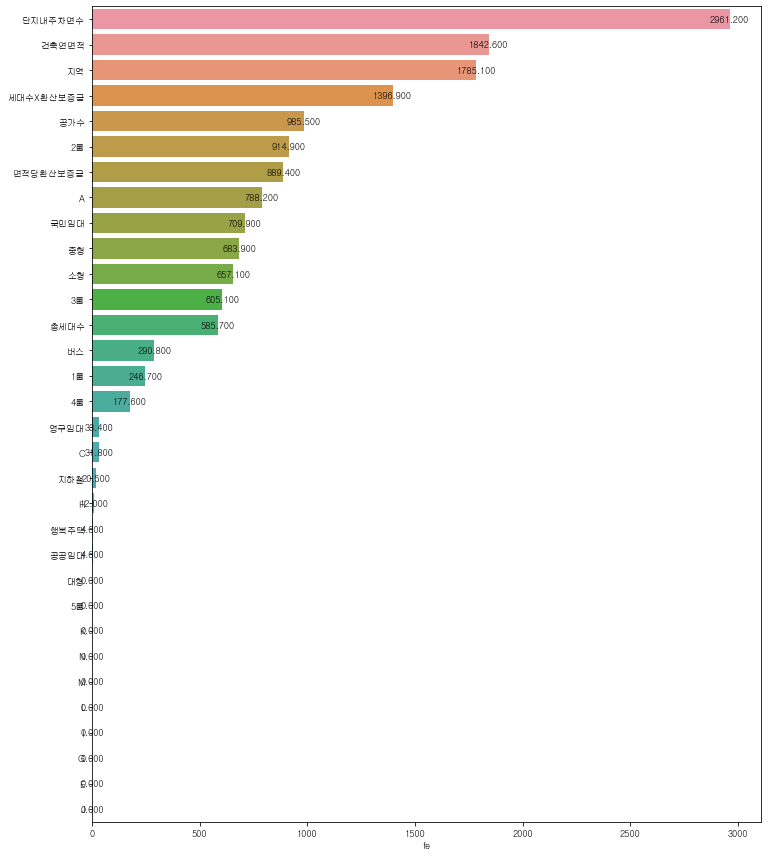

In [1076]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(np.array(fe).mean(axis=0),
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## pycaret

In [388]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          #'numeric_features' : None,
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : True,
          'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          'ignore_low_variance' : True,
          'combine_rare_levels' : False,
          'rare_level_threshold' : 0.10,
          'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          'remove_multicollinearity' : True,
          'multicollinearity_threshold' : 0.9,
          'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          'feature_selection' : True,
          'feature_selection_threshold' : 0.8,
          'feature_interaction' : False,
          'feature_ratio' : False,
          'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          'data_split_shuffle' : True,
          'n_jobs' : -1,
          'html' : True,
          'session_id' : 42,
          'log_experiment' : False,
          'experiment_name' : None,
          'log_plots' : False,
          'log_profile' : False,
          'log_data' : False,
          'silent': False,
          'verbose' : True,
          'profile' : False}

In [398]:
exp_clf101 = setup(**params,
                   data = train, target = '등록차량수')

In [400]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

In [928]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          #'numeric_features' : None,
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : False,
          #'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          #'ignore_low_variance' : True,
          #'combine_rare_levels' : False,
          #'rare_level_threshold' : 0.10,
          #'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          #'remove_multicollinearity' : True,
          #'multicollinearity_threshold' : 0.9,
          #'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          #'feature_selection' : True,
          #'feature_selection_threshold' : 0.8,
          #'feature_interaction' : False,
          #'feature_ratio' : False,
          #'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          #'data_split_shuffle' : True,
          'n_jobs' : -1,
          #'html' : True,
          'session_id' : 42,
          #'log_experiment' : False,
          #'experiment_name' : None,
          #'log_plots' : False,
          #'log_profile' : False,
          #'log_data' : False,
          #'silent': False,
          #'verbose' : True,
          #'profile' : False
         }

In [930]:
exp_clf101 = setup(**params,
                   data = train, target = '등록차량수')

In [931]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

In [394]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          'numeric_features' : ['G', 'M'],
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : False,
          #'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          #'ignore_low_variance' : True,
          #'combine_rare_levels' : False,
          #'rare_level_threshold' : 0.10,
          #'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          #'remove_multicollinearity' : True,
          #'multicollinearity_threshold' : 0.9,
          #'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          'feature_selection' : True,
          'feature_selection_threshold' : 0.8,
          #'feature_interaction' : False,
          #'feature_ratio' : False,
          #'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          #'data_split_shuffle' : True,
          'n_jobs' : -1,
          #'html' : True,
          'session_id' : 42,
          #'log_experiment' : False,
          #'experiment_name' : None,
          #'log_plots' : False,
          #'log_profile' : False,
          #'log_data' : False,
          #'silent': False,
          #'verbose' : True,
          #'profile' : False
         }

In [395]:
exp_clf101 = setup(**params, data = train, target = '등록차량수')

In [396]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])